In [1]:
import pickle
import json
import os
import re
import sys
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
import tifffile
import yaml
from matplotlib.collections import PolyCollection
from matplotlib.colors import TwoSlopeNorm
from einops import rearrange, repeat
from pydantic_extra_types.color import Color

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.multiplex as multiplex
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.cosmx as cosmx
import mushroom.visualization.tiling_utils as tiling_utils

In [6]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [7]:
run_dir = '/data/estorrs/mushroom/data/projects/submission_v1'

In [8]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
        
    return config

In [9]:
# case = 'HT913Z1'
# case = 'HT891Z1'
# case = 'HT704B1'
# case = 'HT206B1'
case = 'HT397B1'
# case = 'HT413C1-Th1k4A1'

In [10]:
project_dir = Path(f'/data/estorrs/mushroom/data/projects/submission_v1/{case}')

In [11]:
fig_dir = project_dir / 'figures' 
fig_dir.mkdir(parents=True, exist_ok=True)

In [12]:
config = yaml.safe_load(open(os.path.join(project_dir, 'registered', 'metadata.yaml')))
config = alter_filesystem(config, source_root, target_root)
config

{'resolution': 1.0,
 'sections': [{'data': [{'dtype': 'visium',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s0_HT397B1-U1_visium_scaled.h5ad'},
    {'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s0_HT397B1-U1_he_scaled.tif'}],
   'position': 0,
   'sid': 'HT397B1-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s1_HT397B1-U2_multiplex_scaled.ome.tiff'}],
   'position': 5,
   'sid': 'HT397B1-U2'},
  {'data': [{'dtype': 'batch2_he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s2_HT397B1-U4_batch2_he_scaled.tif'}],
   'position': 15,
   'sid': 'HT397B1-U4'},
  {'data': [{'dtype': 'batch2_he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s3_HT397B1-U8_batch2_he_scaled.tif'}],
   'position': 35,
   'sid': 'HT397B1-U8'},
  {'dat

In [13]:
sid_to_z = {entry['sid']:i for i, entry in enumerate(config['sections'])}

In [14]:
imaris_dir = project_dir / 'imaris' / 'rois'
imaris_dir.mkdir(parents=True, exist_ok=True)

In [15]:
full_rgb_dir = imaris_dir / 'full_rgbs'
full_rgb_dir.mkdir(parents=True, exist_ok=True)

###### saving full

In [16]:
full_rgb_dir = imaris_dir / 'full_rgbs'
full_rgb_dir.mkdir(parents=True, exist_ok=True)

In [17]:
case_to_multiplex_view_settings = {
    'HT913Z1': [
        {
            'channel': 'E-Cadherin',
            'color': 'red',
            'min_value': 15,
            'max_value': 100,
            'gamma': 1.
        },
        {
            'channel': 'HLA-DR',
            'color': 'yellow',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'CK5',
            'color': 'white',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'CD3e',
            'color': 'green',
            'min_value': 20,
            'max_value': 75,
            'gamma': 1.
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
    ],
    'HT891Z1': [
        {
            'channel': 'E-Cadherin',
            'color': 'red',
            'min_value': 15,
            'max_value': 100,
            'gamma': 1.
        },
        {
            'channel': 'HLA-DR',
            'color': 'yellow',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'CK5',
            'color': 'white',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'CD3e',
            'color': 'green',
            'min_value': 20,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
    ],
    'HT704B1': [
        {
            'channel': 'Pan-Cytokeratin',
            'color': 'red',
            'min_value': 15,
            'max_value': 100,
            'gamma': 1.
        },
        {
            'channel': 'HLA-DR',
            'color': 'yellow',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'Keratin 5',
            'color': 'white',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'CD3e',
            'color': 'green',
            'min_value': 20,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
    ],
    'HT206B1': [
        {
            'channel': 'Pan-Cytokeratin',
            'color': 'red',
            'min_value': 15,
            'max_value': 100,
            'gamma': 1.
        },
        {
            'channel': 'HLA-DR',
            'color': 'yellow',
            'min_value': 15,
            'max_value': 150,
            'gamma': 1.
        },
        {
            'channel': 'SMA (D)',
            'color': 'white',
            'min_value': 15,
            'max_value': 150,
            'gamma': 1.
        },
        {
            'channel': 'Podoplanin (D)',
            'color': 'white',
            'min_value': 15,
            'max_value': 65,
            'gamma': 1.
        },
        {
            'channel': 'CD4 (D)',
            'color': 'green',
            'min_value': 20,
            'max_value': 165,
            'gamma': 1.
        },
        {
            'channel': 'CD45 (D)',
            'color': 'cyan',
            'min_value': 40,
            'max_value': 130,
            'gamma': 1.
        },
    ],
    'HT397B1': [
        {
            'channel': 'Pan-Cytokeratin',
            'color': 'red',
            'min_value': 15,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'HLA-DR',
            'color': 'yellow',
            'min_value': 20,
            'max_value': 255,
            'gamma': 1.
        },
        {
            'channel': 'Keratin 14',
            'color': 'white',
            'min_value': 25,
            'max_value': 100,
            'gamma': 1.
        },
        {
            'channel': 'CD8',
            'color': 'green',
            'min_value': 10,
            'max_value': 31,
            'gamma': 1.
        },
        {
            'channel': 'CD45 (D)',
            'color': 'cyan',
            'min_value': 15,
            'max_value': 35,
            'gamma': 1.
        },
    ]
}

In [18]:

multiplex_view_settings = case_to_multiplex_view_settings[case]

def get_multiplex_pseudo(fp, view_settings):
    channels = [x['channel'] for x in view_settings]
    colors = [x['color'] for x in view_settings]
    min_values = [x['min_value'] for x in view_settings]
    max_values = [x['max_value'] for x in view_settings]
    gammas = [x['gamma'] for x in view_settings]
    
    channel_to_img = multiplex.extract_ome_tiff(fp, as_dict=True)
    data = np.stack([channel_to_img[x] for x in channels])
    
    rgb = multiplex.to_pseudocolor(
        data,
        colors=colors,
        min_values=min_values,
        max_values=max_values,
        gammas=gammas
    )
    
    rgb *= 255.
    rgb = rgb.astype(np.uint8)
    
    return rgb

In [19]:
XENIUM_FOCUS_SETTINGS = [
    {
        'channel': 'DAPI',
        'color': 'blue',
        'min_value': 0,
        'max_value': 100,
        'gamma': 1.
    },
    {
        'channel': 'ATP1A1/CD45/E-Cadherin',
        'color': 'magenta',
        'min_value': 0,
        'max_value': 100,
        'gamma': 1.
    },
                         {
        'channel': '18S',
        'color': 'yellow',
        'min_value': 0,
        'max_value': 50,
        'gamma': 1.
    },
                         {
        'channel': 'alphaSMA/Vimentin',
        'color': 'green',
        'min_value': 0,
        'max_value': 100,
        'gamma': 1.
    },
]

case_to_xenium_view_settings = {
    'HT913Z1': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'TP63',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'KRT5',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CP',
            'color': 'purple',
            'marker': 'P',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
    'HT891Z1': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'TP63',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'KRT5',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CP',
            'color': 'purple',
            'marker': 'P',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
    'HT704B1': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'KRT5',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'TP63',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
    'HT206B1': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'ACTA2',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'PDPN',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
    'HT397B1': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'KRT5',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
}

xenium_view_settings = case_to_xenium_view_settings[case]

def get_xenium_pseudo(morph_fp, focus_settings):
    cs = multiplex.get_ome_tiff_channels(morph_fp)
    if len(cs) == 1: # just nuclei
        channels = ['DAPI']
        colors = ['white']
        min_values = [0.]
        max_values = [100.]
        gammas = [1.]
    else: # multiple channels
        channels = [x['channel'] for x in focus_settings]
        colors = [x['color'] for x in focus_settings]
        min_values = [x['min_value'] for x in focus_settings]
        max_values = [x['max_value'] for x in focus_settings]
        gammas = [x['gamma'] for x in focus_settings]
    
    channel_to_img = multiplex.extract_ome_tiff(morph_fp, as_dict=True)
    data = np.stack([channel_to_img[x] for x in channels])
    
    rgb = multiplex.to_pseudocolor(
        data,
        colors=colors,
        min_values=min_values,
        max_values=max_values,
        gammas=gammas
    )
    
    rgb *= 255.
    rgb = rgb.astype(np.uint8)
    
    return rgb

def plot_xenium_pseudo(ax, rgb, transcripts, view_settings, s=.1):
    ax.imshow(rgb)
    
    if not isinstance(transcripts, pd.DataFrame):
        transcripts = pd.read_parquet(transcripts)
        
    pool = set(transcripts['feature_name'])
    for entry in view_settings:
        color = np.asarray(Color(entry['color']).as_rgb_tuple()) / 255.
        channel = entry['channel']
        marker = entry['marker']
        
        if channel in pool:
            small = transcripts[transcripts['feature_name']==channel]
            X = small[['y_location', 'x_location']].values.astype(int)
            ax.scatter(X[:, 1], X[:, 0], color=color, s=s, marker=marker, edgecolors='none')
    return ax

def add_transcripts_to_rgb(rgb, transcripts, xenium_view_settings, pt_scaler=50):
    if not isinstance(transcripts, pd.DataFrame):
        transcripts = pd.read_parquet(transcripts)

    size = (rgb.shape[1] / 1000, rgb.shape[0] / 1000)
    fig, ax = plt.subplots(figsize=(rgb.shape[1] / 1000, rgb.shape[0] / 1000))
    ax.set_axis_off()
    ax = plot_xenium_pseudo(ax, rgb, transcripts, xenium_view_settings, s=size[0] / pt_scaler)
    plt.savefig('temp.tif', bbox_inches='tight', pad_inches=0, dpi=int(1000 * 1.2987411728584588))
    rgb = tifffile.imread('temp.tif')
    os.remove('temp.tif')
    
    if rgb.shape[-1] == 4:
        rgb = rgb[..., :-1]
    
    return rgb



In [20]:
COSMX_FOCUS_SETTINGS = [
    {
        'channel': 'DNA',
        'color': 'blue',
        'min_value': 0,
        'max_value': 100,
        'gamma': 1.
    },
    {
        'channel': 'PanCK',
        'color': 'red',
        'min_value': 0,
        'max_value': 25,
        'gamma': 1.
    },
#     { # makes things messy
#         'channel': 'Membrane',
#         'color': 'yellow',
#         'min_value': 0,
#         'max_value': 100,
#         'gamma': 1.
#     },
    {
        'channel': 'CD68',
        'color': 'cyan',
        'min_value': 2,
        'max_value': 13,
        'gamma': 1.
    },
                         {
        'channel': 'CD45',
        'color': 'green',
        'min_value': 1,
        'max_value': 10,
        'gamma': 1.
    },
]

case_to_cosmx_view_settings = {
    'HT704B1': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'KRT5',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'TP63',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
    'HT206B1': [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'HLA-DQB2',
            'color': 'yellow',
            'marker': 'v',
        },
        {
            'channel': 'ACTA2',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'PDPN',
            'color': 'white',
            'marker': 's',
        },
        {
            'channel': 'CD3E',
            'color': 'limegreen',
            'marker': '*',
        },
        {
            'channel': 'CD68',
            'color': 'cyan',
            'marker': 'D',
        },
    ],
}

cosmx_view_settings = case_to_cosmx_view_settings.get(case)

In [21]:
VISHD_GENE = 'KRT5'
def add_bins_to_rgb(rgb, pts, color='white', pt_scaler=50, s=.1, marker='s'):
    size = (rgb.shape[1] / 1000, rgb.shape[0] / 1000)
    fig, ax = plt.subplots(figsize=(rgb.shape[1] / 1000, rgb.shape[0] / 1000))
    ax.set_axis_off()
    ax.imshow(rgb)
    ax.scatter(pts[:, 1], pts[:, 0], color=color, s=s, marker=marker, edgecolors='none')
    plt.savefig('temp.tif', bbox_inches='tight', pad_inches=0, dpi=int(1000 * 1.2987411728584588))
    rgb = tifffile.imread('temp.tif')
    os.remove('temp.tif')
    
    if rgb.shape[-1] == 4:
        rgb = rgb[..., :-1]
    
    return rgb

In [23]:
if case in ['HT397B1']:
    target_size = tifffile.imread(config['sections'][1]['data'][0]['filepath']).shape[1:]
    # target_size = [int(x * .5) for x in target_size]
else:
    target_size = xenium.get_fullres_size(xenium.adata_from_xenium(config['sections'][0]['data'][0]['filepath']))

target_size

(6791, 6696)

In [26]:


rgbs = []
for i, section in enumerate(config['sections']):
    print(i, section['sid'])
    sid = section['sid']
    for entry in section['data']:
        dtype = entry['dtype']
        print(dtype)
        fp = entry['filepath']
        position = section['position']

        if dtype in ['he', 'batch2_he']: 
            rgb = tifffile.imread(fp)
            if rgb.shape[0] <= 4:
                rgb = rearrange(rgb, 'c h w -> h w c')
        elif dtype == 'visium':
            he_fp = fp.replace('_visium_scaled.h5ad', '_he_scaled.tif')
            rgb = tifffile.imread(he_fp)
            if rgb.shape[0] <= 4:
                rgb = rearrange(rgb, 'c h w -> h w c')
        elif dtype in ['xenium', 'cosmx']:
            transcripts_fp = fp.replace('.h5ad', '_transcripts.parquet')
            morph_fp = fp.replace('.h5ad', '_morphologyfocus.ome.tiff')
            assert Path(transcripts_fp).exists()
            assert Path(morph_fp).exists()
            rgb = get_xenium_pseudo(
                morph_fp,
                XENIUM_FOCUS_SETTINGS if dtype == 'xenium' else COSMX_FOCUS_SETTINGS
            )
            rgb = add_transcripts_to_rgb(
                rgb, transcripts_fp,
                xenium_view_settings if dtype == 'xenium' else cosmx_view_settings
            )
        elif dtype == 'multiplex':
            rgb = get_multiplex_pseudo(
                fp,
                multiplex_view_settings
            )
        elif dtype == 'vishd':
            he_fp = fp.replace('.h5ad', '_he.ome.tiff')
            assert Path(he_fp).exists()
            rgb = rearrange(tifffile.imread(he_fp), 'c h w -> h w c')
            adata = sc.read_h5ad(fp)
            
            pts = adata.obs[['y_location', 'x_location']].values.astype(int)
            mask = adata[:, VISHD_GENE].X.toarray().flatten() > 0

            filtered_pts = pts[mask]
            vals = adata[mask, VISHD_GENE].X.toarray().flatten()
            rgb = add_bins_to_rgb(rgb, filtered_pts, color='white')
        else:
            rgb = None

        if rgb is not None:
            if rgb.shape[:2] != target_size:
                rgb = utils.rescale(rgb, size=target_size, dim_order='h w c', target_dtype=rgb.dtype)
            tifffile.imwrite(full_rgb_dir / f'{sid}.tif', rgb, compression='LZW')


0 HT397B1-U1
visium
he
1 HT397B1-U2
multiplex
2 HT397B1-U4
batch2_he
3 HT397B1-U8
batch2_he
4 HT397B1-U11
batch2_he
5 HT397B1-U12
multiplex
6 HT397B1-U16
batch2_he
7 HT397B1-U21
visium
he
8 HT397B1-U22
multiplex
9 HT397B1-U20
batch2_he
10 HT397B1-U28
batch2_he
11 HT397B1-U31
multiplex


###### save tiled data

In [27]:
tiled_dir = imaris_dir / 'tiled'
tiled_dir.mkdir(parents=True, exist_ok=True)

In [28]:
seen = set()
sid_to_channels = {}
dtype_to_count = {}
dtype_ident_to_dtype = {}
dtype_ident_to_channels = {}
channels_to_dtype_ident = {}
sid_to_dtype_ident = {}
for i, section in enumerate(config['sections']):
    print(i, section['sid'])
    sid = section['sid']
    fp = section['data'][0]['filepath']
    dtype = section['data'][0]['dtype']
    
    if 'multiplex' in dtype:
        channels = multiplex.get_ome_tiff_channels(fp)
    elif dtype == 'xenium':
        adata = xenium.adata_from_xenium(fp)
        channels = adata.var.index.to_list()
    elif dtype == 'cosmx':
        adata = cosmx.adata_from_cosmx(fp)
        channels = adata.var.index.to_list()
    elif dtype == 'vishd':
        adata = sc.read_h5ad(fp)
        adata.var_names_make_unique()
        channels = adata.var.index.to_list()
    elif dtype == 'visium':
        adata = sc.read_h5ad(fp)
        adata.var_names_make_unique()
        channels = adata.var.index.to_list()
    elif 'he' in dtype:
        channels = ['red', 'green', 'blue']
    else:
        raise RuntimeError(f'dtype {dtype} not recongnized')
    
    sid_to_channels[sid] = channels
    
    if dtype not in dtype_to_count:
        dtype_to_count[dtype] = 0
    
    if tuple(channels) not in seen:
        seen.add(tuple(channels))
        dtype_ident = f'{dtype}_{dtype_to_count[dtype]}'
        dtype_ident_to_channels[dtype_ident] = channels
        channels_to_dtype_ident[tuple(channels)] = dtype_ident
        dtype_ident_to_dtype[dtype_ident] = dtype
        dtype_to_count[dtype] += 1
    
    sid_to_dtype_ident[sid] = channels_to_dtype_ident[tuple(channels)]



0 HT397B1-U1
1 HT397B1-U2
2 HT397B1-U4
3 HT397B1-U8
4 HT397B1-U11
5 HT397B1-U12
6 HT397B1-U16
7 HT397B1-U21
8 HT397B1-U22
9 HT397B1-U20
10 HT397B1-U28
11 HT397B1-U31


In [29]:
for dti, channels in dtype_ident_to_channels.items():
    print(dti, len(channels))

visium_0 17943
multiplex_0 25
batch2_he_0 3
multiplex_1 27
multiplex_2 25


In [30]:
fullres_size = xenium.get_fullres_size(xenium.adata_from_xenium(config['sections'][0]['data'][0]['filepath']))
tiling_size = 10
tiling_resolution = tiling_size
size = [x // tiling_size for x in fullres_size]
size

[678, 669]

In [32]:
dti_to_fps = {}
for dtype_ident, channels in dtype_ident_to_channels.items():
    dtype = dtype_ident_to_dtype[dtype_ident]
    if dtype not in ['vishd', 'visium']:
        # get sids for all other dtype idents of same dtype
        other = [dti for dti in dtype_ident_to_channels.keys()
                if dti != dtype_ident
                if dtype_ident_to_dtype[dti] == dtype]
        drop = [sid for sid, dti in sid_to_dtype_ident.items()
               if dti in other]
        print(dtype, dtype_ident, len(channels), drop)

        use_transcripts = len(channels) < 2000
        tiled = tiling_utils.get_tiled_sections(
            config, dtype=dtype, channel_names=channels, drop=drop,
            tiling_size=tiling_size, target_size=size, use_transcripts=use_transcripts
        )
        dti_to_fps[dtype_ident] = str(tiled_dir / f'{dtype_ident}.tif')
        tifffile.imwrite(tiled_dir / f'{dtype_ident}.tif', tiled, compression='LZW')

multiplex multiplex_0 25 ['HT397B1-U22', 'HT397B1-U31']
/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s1_HT397B1-U2_multiplex_scaled.ome.tiff
/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s5_HT397B1-U12_multiplex_scaled.ome.tiff
batch2_he batch2_he_0 3 []
/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s2_HT397B1-U4_batch2_he_scaled.tif
/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s3_HT397B1-U8_batch2_he_scaled.tif
/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s4_HT397B1-U11_batch2_he_scaled.tif
/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s6_HT397B1-U16_batch2_he_scaled.tif
/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s9_HT397B1-U20_batch2_he_scaled.tif
/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/registered/s10_HT397B1-U28_batch2_he_scaled.tif
multiplex multiplex_1 27 ['HT397B1-U2', 'HT397B1-U12', 'HT397

In [33]:
meta = {
    'sid_to_channels': sid_to_channels,
    'dtype_ident_to_dtype': dtype_ident_to_dtype,
    'dtype_ident_to_channels': dtype_ident_to_channels,
    'sid_to_dtype_ident': sid_to_dtype_ident,
    'tiling_size': tiling_size,
    'size': size,
    'fullres_size': fullres_size,
    'dtype_ident_to_tiled_fps': dti_to_fps
}
json.dump(meta, open(tiled_dir / 'metadata.json', 'w'))

In [34]:
# for dti, tiled in dtype_ident_to_tiled.items():
#     print(dti, tiled.shape)
#     tifffile.imwrite(tiled_dir / f'{dti}.tif', tiled, compression='LZW')

###### roi specific

In [36]:
case_to_rois = {
    'HT891Z1': {
        'roi1': (1300, 2100, 2500, 3500), # normal -> gp3
        'roi2': (4650, 5650, 1900, 2900), # normal -> gp3
        'roi2-p2': (4650, 5650, 1900, 2900), # PIN -> gp3
    },
    'HT913Z1': {
        'roi1': (4000, 4750, 5800, 7200), # normal -> gp3
        'roi1-p2': (4000, 4750, 5800, 7200) # normal -> gp3
    },
    'HT704B1': {
        'roi1': (2400, 3000, 5800, 6600), # DCIS -> IDC
        'roi2': (3700, 4300, 5750, 6500), # DCIS -> partial IDC
        'roi3': (0, 7250, 0, 9063), # full region trace of dcis
    },
    'HT206B1': {
        'roi1': (1650, 2600, 4900, 5750), # dcis -> idc
        'roi2': (2700, 4300, 3600, 5500) # dcis -> idc
    },
    'HT397B1': {
        'roi1': (2600, 3700, 3200, 4800)
    }
}

In [37]:
roi = 'roi1'

In [38]:
fps = [full_rgb_dir / name for name in os.listdir(full_rgb_dir)]
R1, R2, C1, C2 = case_to_rois[case][roi]
rgbs, included_sids = [], []
tups = []
for fp in fps:
    sid = str(fp).split('/')[-1].replace('.tif', '')
    z = sid_to_z[sid]
    tups.append((sid, z, str(fp)))

tups = sorted(tups, key= lambda x: x[1])
for sid, z, fp in tups:
    X = tifffile.imread(fp)
    rgbs.append(X[R1:R2, C1:C2])
    included_sids.append(sid)

In [39]:
stacked = np.stack(rgbs)
stacked.shape

(12, 1100, 1600, 3)

In [40]:
multiplex.write_basic_ome_tiff(
    imaris_dir / f'{roi}.ome.tif',
    rearrange(stacked, 'z h w c -> 1 z c h w'),
    ['red', 'green', 'blue'],
    1.
)

In [41]:
sid_to_rgb = {sid:x for sid, x in zip(included_sids, stacked)}

In [42]:
# for i, (sid, rgb) in enumerate(sid_to_rgb.items()):
#     print(i, sid)
#     plt.imshow(rgb)
#     plt.axis('off')
#     plt.show()

In [43]:
imaris_dir

PosixPath('/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/imaris/rois')

In [44]:
meta = json.load(open(imaris_dir / 'tiled' / 'metadata.json'))
meta.keys()

dict_keys(['sid_to_channels', 'dtype_ident_to_dtype', 'dtype_ident_to_channels', 'sid_to_dtype_ident', 'tiling_size', 'size', 'fullres_size', 'dtype_ident_to_tiled_fps'])

In [45]:
sid_to_channels = meta['sid_to_channels']
dtype_ident_to_dtype = meta['dtype_ident_to_dtype']
dtype_ident_to_channels = meta['dtype_ident_to_channels']
sid_to_dtype_ident = meta['sid_to_dtype_ident']
tiling_resolution, tiling_size = meta['tiling_size'], meta['tiling_size']
size = meta['size']
fullres_size = meta['fullres_size']
dtype_ident_to_tiled_fps = meta['dtype_ident_to_tiled_fps']

In [46]:
dtype_ident_to_tiled = {dti:tifffile.imread(fp) for dti, fp in dtype_ident_to_tiled_fps.items()}
for dti, tiled in dtype_ident_to_tiled.items():
    print(dti, tiled.shape)

multiplex_0 (2, 25, 678, 669)
batch2_he_0 (6, 3, 678, 669)
multiplex_1 (1, 27, 678, 669)
multiplex_2 (1, 25, 678, 669)


In [49]:
sid_to_tiled = {}
for dtype_ident in dtype_ident_to_channels.keys():
    if 'vis' not in dtype_ident:
        dtype = dtype_ident_to_dtype[dtype_ident]
        tiled = dtype_ident_to_tiled[dtype_ident]
        sids = [entry['sid'] for entry in config['sections'] if sid_to_dtype_ident[entry['sid']]==dtype_ident]
        for sid, t in zip(sids, tiled):
            sid_to_tiled[sid] = t / t.std(axis=(-2, -1), keepdims=True)
sid_to_tiled.keys()

dict_keys(['HT397B1-U2', 'HT397B1-U12', 'HT397B1-U4', 'HT397B1-U8', 'HT397B1-U11', 'HT397B1-U16', 'HT397B1-U20', 'HT397B1-U28', 'HT397B1-U22', 'HT397B1-U31'])

In [50]:
sid_to_fp = {entry['sid']:entry['data'][0]['filepath'] for entry in config['sections']}
sid_to_dtype = {entry['sid']:entry['data'][0]['dtype'] for entry in config['sections']}

In [149]:
def load_regions(regions_fp):
    regions = json.load(open(regions_fp))['features']
    for x in regions:
        np.asarray(x['geometry']['coordinates'])
    regions = [{'id': x['id'], 'z': x['geometry']['plane']['z'] if 'plane' in x['geometry'] else 0, 'coordinates': np.asarray(x['geometry']['coordinates'])}
               for x in regions]
    regions = [x for x in regions if len(x['coordinates'].shape) == 3]
    for x in regions:
        x['coordinates'] = x['coordinates'][0][:, [1, 0]]
        x['mask'] = skimage.draw.polygon2mask(stacked.shape[1:3], x['coordinates'])

    return regions

In [153]:
regions_fp = imaris_dir / f'{roi}.geojson'
regions = load_regions(regions_fp)

len(regions), regions[0].keys()

(10, dict_keys(['id', 'z', 'coordinates', 'mask']))

In [154]:
blank = np.zeros(size, dtype=bool)
z_to_regions_mask = {}
for region in regions:
    if region['z'] not in z_to_regions_mask:
        z_to_regions_mask[region['z']] = blank.copy()

    coords = region['coordinates'] + np.asarray([R1, C1])
    coords //= tiling_resolution
    mask = skimage.draw.polygon2mask(size, coords)
    z_to_regions_mask[region['z']] |= mask

In [155]:
# just piggy backing visium off this too
sid_to_vishd_roi_adata = {}
for sid, fp in sid_to_fp.items():
    if sid_to_dtype[sid] in ['vishd', 'visium']:
        fp = sid_to_fp[sid]
        adata = sc.read_h5ad(fp)
        adata.var_names_make_unique()
        channels = sid_to_channels[sid]
        adata = adata[:, channels]
        adata.obs['tmp'] = 0 # need to initialize view for some reason
        

        if sid_to_dtype[sid] == 'visium': # put coordinates in same spot as hd
            adata.obs['y_location'] = adata.obsm['spatial'][:, 1]
            adata.obs['x_location'] = adata.obsm['spatial'][:, 0]
        
        m = adata.obs['y_location'] >= R1
        m &= adata.obs['y_location'] < R2
        m &= adata.obs['x_location'] >= C1
        m &= adata.obs['x_location'] < C2
        adata = adata[m]
        adata.obs['y_location'] -= R1
        adata.obs['x_location'] -= C1
        sid_to_vishd_roi_adata[sid] = adata
sid_to_vishd_roi_adata.keys()     

/tmp/ipykernel_3284351/112246470.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['tmp'] = 0 # need to initialize view for some reason
/tmp/ipykernel_3284351/112246470.py:22: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['y_location'] -= R1
/tmp/ipykernel_3284351/112246470.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['tmp'] = 0 # need to initialize view for some reason
/tmp/ipykernel_3284351/112246470.py:22: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['y_location'] -= R1


dict_keys(['HT397B1-U1', 'HT397B1-U21'])

In [156]:
# dtype_to_epi = case_to_dtype_to_epi[case]
local_r1, local_r2, local_c1, local_c2 = [x // tiling_resolution for x in [R1, R2, C1, C2]]
for region in regions:
    sid = config['sections'][region['z']]['sid']
    region['position'] = config['sections'][region['z']]['position']
    dtype = sid_to_dtype[sid]
    dtype_ident = sid_to_dtype_ident[sid]
    channels = dtype_ident_to_channels[dtype_ident]
    regions_mask = z_to_regions_mask[region['z']]
    
    print(sid, dtype_ident)

    coords = region['coordinates'] + np.asarray([R1, C1])
    if sid in sid_to_tiled:
        tiled = sid_to_tiled[sid]
        
        coords //= tiling_resolution
        mask = skimage.draw.polygon2mask(tiled.shape[-2:], coords)

        outer = mask.copy()
        for i in range(1):
            outer = skimage.morphology.binary_dilation(outer)
        inner = mask.copy()
        for i in range(1):
            inner = skimage.morphology.binary_erosion(inner)
        expanded = mask.copy()
        for i in range(5):
            expanded = skimage.morphology.binary_dilation(expanded)
            
        means = tiled[:, mask].mean(1)
        fracs = np.count_nonzero(tiled[:, mask] > 0, axis=1) / np.count_nonzero(mask)

        ring = outer ^ inner
        ring_means = tiled[:, ring].mean(1)
        ring_fracs = np.count_nonzero(tiled[:, ring] > 0, axis=1) / np.count_nonzero(ring)

        tme = expanded ^ outer
#         tme = tme ^ regions_mask
        tme_means = tiled[:, tme].mean(1)
        tme_fracs = np.count_nonzero(tiled[:, tme] > 0, axis=1) / np.count_nonzero(tme)
    elif dtype in ['vishd', 'visium']:
        a = sid_to_vishd_roi_adata[sid] 
        in_region = np.asarray([region['mask'][int(r), int(c)]
                     for r, c in zip(a.obs['y_location'], a.obs['x_location'])])
        X = a[in_region].X
        means = np.asarray(X.mean(0)).flatten()
        fracs = np.asarray([np.nan] * len(means))
        
        outer = region['mask'].copy()
        for i in range(tiling_size):
            outer = skimage.morphology.binary_dilation(outer)
        inner = region['mask'].copy()
        for i in range(tiling_size):
            inner = skimage.morphology.binary_erosion(inner)
        expanded = region['mask'].copy()
        for i in range(5 * tiling_size):
            expanded = skimage.morphology.binary_dilation(expanded)
        
        ring = outer ^ inner
        in_region = np.asarray([ring[int(r), int(c)]
                     for r, c in zip(a.obs['y_location'], a.obs['x_location'])])
        X = a[in_region].X
        ring_means = np.asarray(X.mean(0)).flatten()
        ring_fracs = np.asarray([np.nan] * len(ring_means))
        
        tme = expanded ^ outer
        in_region = np.asarray([tme[int(r), int(c)]
                     for r, c in zip(a.obs['y_location'], a.obs['x_location'])])
        X = a[in_region].X
        tme_means = np.asarray(X.mean(0)).flatten()
        tme_fracs = np.asarray([np.nan] * len(tme_means))
        
        
    else:
        raise RuntimeError(f'dtype {dtype} is invalid')

    region['fracs'] = fracs
    region['means'] = means
    region['fracs_ring'] = tme_means
    region['means_ring'] = tme_fracs
    region['fracs_tme'] = tme_means
    region['means_tme'] = tme_fracs
    region['dtype'] = dtype
    region['dtype_ident'] = dtype_ident
    region['channels'] = channels
    region['ring'] = ring
    region['tme'] = tme
    region['m'] = mask
        
    region['sid'] = sid
        
        


HT397B1-U1 visium_0
HT397B1-U2 multiplex_0
HT397B1-U4 batch2_he_0
HT397B1-U8 batch2_he_0
HT397B1-U11 batch2_he_0
HT397B1-U16 batch2_he_0
HT397B1-U21 visium_0
HT397B1-U22 multiplex_1
HT397B1-U20 batch2_he_0
HT397B1-U12 multiplex_0


In [157]:
region_id_to_region = {x['id']:x for x in regions}

In [158]:
# cmap = plt.colormaps['viridis_r']
# facecolors = [cmap(x) for x in vals]
for x in regions:
    print(np.asarray(x['coordinates']).max(0))

[ 882 1600]
[ 884 1600]
[ 837 1600]
[ 706 1028]
[ 849 1031]
[825 409]
[935 465]
[922 392]
[827 418]
[ 947 1038]


In [159]:
case_to_zeniths = {
    'HT397B1': {
        'roi1': 180,
    },
    'HT206B1': {
        'roi1': 265,
        'roi2': 175,
    },
    'HT704B1': {
        'roi1': 80 + 70,
        'roi2': 80,
        'roi3': 175,
    },
    'HT891Z1': {
        'roi1': 30,
        'roi2': 80,
        'roi2-p2': 80
    },
    'HT913Z1': {
        'roi1': 260,
        'roi1-p2': 260,
    }
}

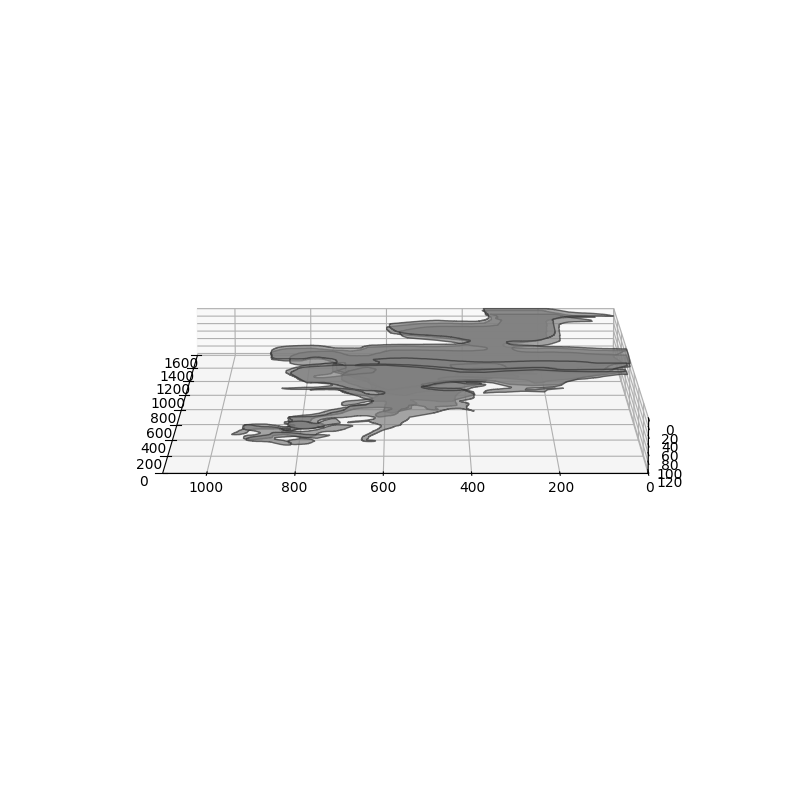

In [160]:
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

coords = [np.asarray(x['coordinates'])[:, [1, 0]] for x in regions]

zs = [x['position'] for x in regions]
facecolors = [(.5, .5, .5, 1.) for i in range(len(zs))]
poly = PolyCollection(coords, facecolors=facecolors, alpha=.7, edgecolor=(.2, .2, .2, 1.))

ax.set(xlim=(0, C2 - C1), ylim=(0, R2 - R1), zlim=(0, max(zs)), aspect='equal')
ax.add_collection3d(poly, zs=zs, zdir='z')
ax.view_init(elev=10., azim=case_to_zeniths[case][roi])
ax.invert_zaxis()
# ax.view_init(elev=10.)
ax.set_aspect('equal')
plt.show()

#### path from connectivity annotations

In [234]:
connectivity_fp = imaris_dir / f'{roi}_aligned.geojson'
conn_regions = load_regions(connectivity_fp)

len(conn_regions), conn_regions[0].keys()

FileNotFoundError: [Errno 2] No such file or directory: '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/imaris/rois/roi2_aligned.geojson'

In [ ]:
assert len(set([x['id'] for x in conn_regions]).intersection(set([x['id'] for x in regions]))) == len(regions)

In [235]:
# def regions_to_volume(regions):
#     zs = [region['z'] for region in regions]
#     rgb = next(iter(sid_to_rgb.values()))
#     labeled = np.zeros((max(zs) + 1, *rgb.shape[:2]))
#     region_id_to_label = {}
#     for i, region in enumerate(regions):
#         sid = config['sections'][region['z']]['sid']
#         coords = region['coordinates'] + np.asarray([r1, c1])
#         coords //= tiling_resolution
#         mask = skimage.draw.polygon2mask(rgb.shape[:2], coords)
#         labeled[region['z'], mask] = i + 1
#         region_id_to_label[region['id']] = i + 1

#     return labeled.astype(int), region_id_to_label
def regions_to_volume(regions):
    zs = [region['z'] for region in regions]
    h, w = R2 - R1, C2 - C1
    labeled = np.zeros((max(zs) + 1, h, w))
    region_id_to_label = {}
    for i, region in enumerate(regions):
        sid = config['sections'][region['z']]['sid']
        coords = region['coordinates']
        mask = skimage.draw.polygon2mask((h, w), coords)
        labeled[region['z'], mask] = i + 1
        region_id_to_label[region['id']] = i + 1

    return labeled.astype(int), region_id_to_label

In [ ]:
labeled, region_id_to_label = regions_to_volume(conn_regions)
label_to_region_id = {v:k for k, v in region_id_to_label.items()}

In [ ]:
def graph_from_labeled(labeled):
    edges = []
    for i in range(labeled.shape[0]):
        m1, m3 = None, None
        m2 = labeled[i]
        if i == 0:
            m3 = labeled[i + 1]
        elif i == labeled.shape[0] - 1:
            m1 = labeled[i - 1]
        else:
            m1 = labeled[i - 1]
            m3 = labeled[i + 1]
        
        labels = [l for l in np.unique(m2) if l]
        for label in labels:
            if m1 is not None:
                overlap = [l for l in np.unique(m1[m2==label]) if l]
                for l in overlap:
                    edges.append((label, l))
            if m3 is not None:
                overlap = [l for l in np.unique(m3[m2==label]) if l]
                for l in overlap:
                    edges.append((label, l))
        
    return edges

In [ ]:
edges = graph_from_labeled(labeled)

In [ ]:
import networkx as nx

In [ ]:
G = nx.Graph()
G.add_edges_from(edges)

In [ ]:
terminals = [k for k, v in G.adj.items() if len(v) == 1]
terminals

In [ ]:
[c for c in sorted(nx.connected_components(G), key=len, reverse=True)]

In [ ]:
assert len(list(nx.connected_components(G))) == 1

In [ ]:
# missing = []
# for i, x in enumerate(labeled):
#     m = np.zeros_like(x, dtype=bool)
#     for node in missing:
#         m |= x==node
#     plt.imshow(m)
#     plt.title(i)
#     plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx(G, font_size=6, node_size=100)

In [ ]:
case_to_endpoints = {
    'HT891Z1': {
        'roi1': ('f6032595-1fd0-44c2-82b0-72a3fac80f03', '18073a83-5d22-4c2a-8cc8-e1b27a4de88e')
    }
}

In [ ]:
endpoints = case_to_endpoints[case][roi]

In [ ]:
n1, n2 = endpoints
path = nx.algorithms.shortest_path(G, region_id_to_label[n1], region_id_to_label[n2])
path

In [ ]:
keep = [label_to_region_id[l] for l in path]

#### user defined path

In [161]:
# keep = re.split(r'\nObject ID\t', """
# Object ID	28e4e782-02a6-42f5-8b12-5545c85edbc5
# Object ID	9b273882-70cd-4f31-b2a3-4fcb89a3d861
# Object ID	9ade75e2-df25-43b5-ad83-8b4bf6575ecd
# Object ID	57772e61-6c1d-40f1-921d-c79edb578378
# Object ID	3331f2c7-2ed4-45e8-a9a2-ff1c9ec02a4a
# Object ID	23e634ac-1dd0-46b8-aca1-99ea86d39753
# Object ID	c904b121-cc85-4e00-b350-5e6f21f8b64a
# Object ID	e449ad11-2d42-45a8-9264-d395e89191b2
# Object ID	b909d252-1bfe-421d-9183-a2a93cafd163
# Object ID	778fd5c6-456d-45dc-ac09-f72565cd6129""")[1:]
# keep

In [162]:
# # keep.reverse()
# # keep
# x = ['406ac3bf-8609-4786-a1df-6540b4970cea',
#             '8cc2c7fe-be42-401d-b779-18b77ac156a3',
#             '12c03edc-81d2-432f-9809-34efbed321d3',
#             '13b32752-7032-4403-a855-75b2a2320799',
#             '7ecb5ca3-161b-41da-bc89-1b64312c5840',
#             'e86f2c46-6822-4fb0-b8fb-ee0adda87027',
#             '5769757d-7e89-49a6-97e1-8a8419989506',
#             'b5c5ff29-07e4-4ad1-a866-0e3bb78f4283',
#             'c4380e8c-f7ad-4cfc-a4f3-ed430ec2c1bc',
#             '227dad79-9f9d-465b-8543-0605892b42b3',
#             '34b75982-a611-4e25-a583-bf10aafdd5bc',
#             'dc5f3e39-0bea-41d3-b152-8d91c0e1ca17',
#             '60111347-4dcd-465d-8537-82cb1cc5484e',
#             'db3c0014-4c41-49db-9d74-e88f28041aee',
#             'a29d8f43-06d4-4e0f-a059-8a4b9fbf959f',
#             'f47c43ed-3e83-4a2f-86d6-aed44f1316c4',
#             '715e36a2-3832-41a6-8cf3-5a28caf458e8',
#             'acaef067-ff89-4676-b10c-6b5f4fd6560e',
#             'cdef0207-f9b5-4a6b-bdf5-bde6df9f9282',
#             'acaef067-ff89-4676-b10c-6b5f4fd6560e',
#             'fc0a0ccf-7386-416f-b163-99041f2d8918',
#             'f8919fee-046b-436a-b728-94c76c3a153b',
#             '686d4c90-0af6-467a-9134-39f483b04c28',
#             '0070e7b1-9e6b-4cda-af13-b5d6238e97ed',
#             'cbf8e855-8a31-4990-b144-064f544d3066',
#             'e5d1214b-8f62-403c-833a-53032515931c',
#             '24000119-0a82-45c1-8505-dc90901e014f',
#             'cb76f6eb-6278-452d-bb4d-9726d650aec9',
#             'f5c166e7-d9db-4bad-b55f-73a0f0799d60',
#             '2a3facce-de6a-43a7-926b-8fbe42ed75b0',
#             '69f28c38-daa2-4007-85ff-e5a1cf88e3eb',
#             'd32db0ea-a851-4d93-b1bf-430e937a1235',
#             '2feaaa28-3e77-4138-b9a4-0b75f68d2f64',
#             'bcbe6b32-baba-4f9e-bf87-45e5f0660327',
#             'd715e31a-7607-4ac3-b0c2-9456b9244140',
#             '99087c7b-e996-40ed-b0f4-4286822192fa',
#             'b6d1644d-743d-4cf4-9fa0-a43d95ea6baa',
#             'bf6c40d9-bdf2-49a5-a3fe-b6e68d0b77c0',
#             '386d888c-4246-46f5-b7a0-d0a763511097',
#             '90116201-5a8a-4f73-be12-495d21dcf084',
#             '142c7012-69e4-4f2a-b00b-9d350db99fd6',
#             '68f55189-0e6f-41b1-9c65-2823226b8d7e',
#             '511a2ee0-a928-47a5-a586-fab0fb648b99',
#             'f1034984-615e-45a5-a4af-05f2fc4eb1b4',
#             '92b53248-6da0-492a-9c0b-0c2a60946a0d',
#             'b536042f-2705-4627-be52-2465ff038195',
#             '6d7255ad-dc1a-47c4-b99f-6fc5fc3f0772',
# #             '995bd781-223b-4849-a502-640895bcf6d7', has experimental artifact at roi location
#             '9ddde78f-2e7b-4259-9bf9-efdd0a005b79',
#             '79e3353f-c2fe-4d54-8d30-a8a661cf61a1',
#             '2db3f2d8-37ce-4ffa-81ea-7948b9af77ae',
#             'c5facae8-79de-4842-b005-ad9e9d23747e']
# x.reverse()
# x

In [163]:
case_to_keep = {
    'HT704B1': {
        'roi1': [
            'b28d28d2-098a-41aa-8a99-24f8c8753897',
            'efac94bc-f48c-410e-a57d-3cfccc9f95f5',
            'e1967bc8-a7b8-4c08-94f1-20963ffb9e7d',
            'bdb3ea48-34e3-43e8-b8b6-042ab38be524',
            '25f59172-9dc6-4340-a21f-2a2b557176cf',
            '4ea3de46-c2ce-477d-a329-e30488ea405a',
            '20e99f45-3070-4653-8b26-9f9ea56631cb',
            '5f27e9f9-b7cd-4baa-a8a7-134777c849e3',
            'b900774e-7d72-4393-b87c-368c0e6196c9',
#             'f94eb1df-7ba2-40db-8bc2-00ccff0c9bf1', # bad quality xenium
            '3190089c-4751-45f2-8860-40fadce6efdf',
            'd2fff7b6-cee3-404e-abc3-e1b7d7e0a6c6',
            'c6b2d74c-93d1-47d9-90f4-fd6e7d1c18a0',
            '575ddaa1-d483-4c8f-a873-fd20c6322400',
            '0831e146-2e3e-45e3-98ed-3848c95e2694',
            '3dcff188-4448-4511-9576-f5d6397b5c5f',
            '8f7fd7f0-ca13-43d5-a8a5-bc46e8f9b687',
            '817b1cde-8242-47cc-bc35-c905ed2509a4',
            '4e8aaa54-1f8d-4c5c-9447-ff3ee99b1e05',
            '606319be-6df3-4fb7-85f4-0c62f2738122',
            '5121309d-39c8-49a3-b654-5107a10ff03e',
            'e741aea8-1b68-4e57-a1f1-0b922bdb0c35',
            'a4719551-76dd-4117-a82a-c086568f52f2',
            'd2851db4-5e2d-455a-a427-116d37309159',
            '25defdcc-c8c1-4511-9ace-d9dbf639f2b6',
            'a8828943-5520-4944-a509-4138d186b364',
            '90fa10dc-bf88-4ddc-b61b-2a9ac96efa9d',
            '944f7780-d678-49ec-8bd3-82a2d66d139b',
            '7ee62508-a502-404f-b93c-47d0fa181aab',
            '65e2995d-ee34-4db9-9c15-089ff4cb9a98',
            'c9a69fca-8cb9-49d5-8e6a-994a48970c3d',
            'ba166553-c235-4975-add0-1c23f41c356c',
            'd47f5943-f0ca-4244-b509-ecaf6e1c118f',
            'add69252-85f8-4f3e-b8ae-896d0e253891',
            '547b86b0-71a2-477a-a490-43d30da4e237'
        ],
        'roi2': [
            'c2df8514-9463-481a-9b68-c81dd634bb9a',
            '90562e73-1e6b-4137-9993-08a7ce2fbae7',
            '95a69bda-c19c-4245-ad98-3d7fe3c42040',
            '86a1ef36-f5b8-49a5-947c-712086be4462',
            '20f14b1b-4032-46fe-a144-aef4e4d275e3',
            '18ca3507-f9aa-4b71-a85e-acc3086fd4ef',
            '54dac54a-982e-4f59-b140-68e74a1d8a37',
            'c20bd90b-9c63-4e32-ac29-b9433b829bce',
            '7b3c20d2-6713-4768-b5cb-c8be3b10beb3',
            '0e25d6d6-ce97-4ccc-a5bf-14de02812aca',
            'd0b4424c-7884-4326-ba44-6922f879b03a',
            'a41a8966-eb30-4e6d-a156-022aa835ec19',
            '2369a573-9f4e-4728-b6f3-d371a362a430',
            'f2b0563a-8f24-4bc8-8cf2-a13b22337303',
            'e01cf432-8d04-4def-8ce3-cf2ba1af2922',
            '244c386c-93ac-4a5f-bf52-43dcce7a1388',
            '64a35b14-07ff-4c3b-9e91-36b7ef068929',
            'd5b3c3e0-1587-4035-a170-a6cad89409b0',
            'e1da80e0-522a-4a17-a1c1-40e607519d9b',
            '32822652-ce81-4c73-8dde-eeae8b9281d1',
            '7825ad91-6cdf-438f-9c23-5355b493abe1',
            '2590d0c4-2c49-4784-88bd-5dfed44f5f8d',
            'c5054881-2aae-41d8-8490-f5aaeaa4595c',
            '663ebb62-c6c8-4e76-9e6f-731c6285a61f',
            '6b8e5fa7-f29d-4f9b-adaa-80f65ebf6ea9',
            'f230f869-5d5b-4c32-bb99-37430b0e10ea',
            '42e24741-6683-4ddf-ab89-5cf26c56bf78',
            '1c6f258e-dd72-45ac-9874-71565653f6f8',
            'be4a61b7-8871-473d-9f74-f796cd4ef770',
            '7aece61f-8a2b-4fba-99ce-2672dbc9d8b6'
        ],
        'roi3': [
            'd9293330-df8b-43f9-8b88-2375643b60aa',
            '5cb05ed3-2b22-4fd7-bedf-dc8a789df2c0',
            '7a787adf-8fba-403e-9f14-6e1031dcc49a',
            '15f75816-6cc4-4003-a1dd-1cb39ba6d792',
            'f3f5a129-0688-4a27-8b9f-417d87319d31',
            'feb5fb14-b1db-4fa6-b190-74d5c2e9b509',
            'a991b564-c33e-4556-b5d7-06ecb611ef4f',
            'e3f4c83f-8e8d-481b-9749-fad97ad55673',
            '71dff1df-d5bb-40c3-a241-659e82e8a43e',
            '8df68aa8-18a4-47a0-9d8b-796d590eadf9',
            'cb24a200-ca1b-4f9c-bec1-04485e7f2a17',
            '9c138875-2b24-4fb4-a836-9c31a86aaa1a',
            '1cf88277-3817-401b-96f9-ff436c17b4e3',
            'b5b50caf-310a-46a9-8625-0117a4cc23ef',
            'd19aa3c9-50d7-472f-b89d-4b0020f6e2c9',
            '087dda61-66fa-411c-a0a5-9527a7e91bb7',
            '88d99522-c143-4f13-966a-bfb325d36211',
            '175d7942-999a-4970-81f6-b8628d77bf14',
            '00e77665-e65f-43b8-9384-64e0bc8c2efa',
            'ec2baaa5-3c15-48f3-8fdb-d59297f5b1d8',
            'a09d553a-cfd4-4208-8032-d43ea9e75372',
            '55161b6a-6570-4654-ab41-4bb649de3486',
            '57658292-92f8-4ccf-9969-84a32f2ec67f',
            '04ede5e9-423a-4413-a576-9ae2982b4941',
            'da771024-21fd-4e08-8bcb-c0c5fa93419d',
            '6ca9ac30-ee2f-4cbe-86ae-5c5bc30db26e',
            'fed4c60e-a0ca-44c0-a4df-1034a44bb28d',
            '4b01c81d-bc2a-4bda-a5d5-d4afd2889ca0',
            '74d2a21d-0e96-4800-a45a-612dd0946146',
            'f2192037-e309-4050-8463-7a7dd863b0e9',
            '514ccfb4-cdbf-4838-96e8-65721c37b573',
            '58416d17-e99c-4995-9247-2cc86194447c',
            '6cfce6d9-5610-4781-949b-1ca5cad57087',
            'd48bb6ba-60e5-48f4-996c-3c0faaef59e8',
            'c492ce64-340e-412a-a14c-d0928649c892',
            '45837c17-2eb5-4085-a667-04093a4037c9',
            'ef1e621d-8d02-465d-bb4a-5f0e9e3063dd',
            'd4f4ff7b-8ab0-4102-9d3d-fc0f0b620fb4',
            '1d94f5df-e4f5-4a46-b760-1dc1d900a81f',
            '692ee84b-fd2d-4021-bdb2-f8a6ea56b3d8',
            '0ae524c6-9584-41b6-aad3-df7a22061e62',
            '5e3df84c-db8f-43da-b544-fda0c46b819c',
            'c8d3e787-5ebf-443f-82b9-eb3beb3dfa79',
            '8c1f24c9-bf6d-44b3-a957-b957dfe56daf',
            '605d019e-9f72-4560-adc0-44545b9e3049',
            'a87a8ff6-6798-41d0-a0b7-ba13345156b6',
            '25975f0b-55ff-42d1-9864-aec5dfe6b464',
            '54bc8c79-1899-4d00-bad4-83fbd1eacffc',
            'd4024e73-63aa-4439-9111-e70638d3949e',
            '5f7bf971-483e-4f23-a7ec-059d86608264',
            '5f2cebc8-1184-41db-9457-84cb12398be5',
            '815124d6-f3f8-42bc-b674-03c35e21e316',
            '554a534b-ce86-4964-a08f-2cd1ae267808',
            '4bb755cf-557d-452b-89c6-516b698af25a',
            '204e48a8-dec1-42f3-a818-35c024f60497',
            'c37f3f22-7770-4704-a86c-63df31be539b',
            '19d2b0e5-36e4-4b07-825f-c7c408a7d132',
            'c7c9fa45-b71f-4dd5-b4ea-a78838de5531',
            'e7c3f450-80cc-4a43-a7e4-a58cf866db51',
            'faabab0f-8c6a-4849-a630-8641dd59a0c1',
            'da0ccd78-1087-499f-8c57-c4ab4c4824cb',
            'e5e34dd7-c045-4707-acd7-1d3ae547d294',
            'ab36522a-2c36-4ac5-9da3-7cd06c864ea5',
            '90cbcbea-d000-4ea6-a3d5-6b8120a2e66b',
            'e3745bbb-7bc2-46bd-bbe4-961d746938b4',
            'd5b14c04-5529-4dc4-8876-44d2df23c99a',
            'ae3cd8e0-5d43-4eee-9da5-56c29c3a019c',
            '84f6f573-1040-4085-8658-f7f9f6ee1f3e',
            '57ecfcff-43d8-424d-90ab-f01f494dfc07',
            'd02a6b8a-b7b9-46b9-9d8d-5aa78e524eb1',
            '1973bb71-877a-4148-8b7f-f8aea56b1cb3',
            'd2fd5bc4-d27e-484f-8f7f-144d9c4c8a80',
            'e12c90f1-f043-4791-898c-2d66a2093bfc',
            'd6ef14d7-5033-48c7-9781-007c2a3c99a2',
            'fa248064-509e-40ea-872c-74405ca242e3',
            '316ff201-b03f-43fb-97a5-12f760d42cac',
            '3e919934-9f0a-454e-a7bb-48b463c9edca',
            '5fd9d674-a08b-4169-a99b-02fc75e03530',
            'e22ec42a-7b22-4f7a-8251-a9d9817234db',
            'a486cb7e-e508-41c0-8dbb-142a49458ae1',
            'ec9e9e1f-d546-4e79-9985-8a9de833946f',
            '40909d6d-4f49-4c1b-ba1d-4f47bef46ec0',
            'acb0503f-4a7b-46c2-b261-0eb852d1bd8d',
            '09c0405e-8aee-4500-aa1f-4d3cf95629a0',
            '7cc52069-18d5-4331-9f48-3ca7ff008e86',
            '3017e782-2594-4894-bea2-fe394307429a',
            'a1dc0f9b-9074-472c-ae87-4d84e7c02a23',
            '1f86a736-b15d-4c0d-9459-5fc3ef05b0bc',
            '02193002-b5c6-4c79-9cc1-c8b01ac0a6ba',
            '6617a8e2-b5f2-46e8-b067-714fab0f62a2',
            '7ebbea05-4f2c-40fd-af67-b519caecdf1a',
            '3ee51c9b-17a6-4dba-8927-26687c68c6fe',
            '60afa4db-7974-4ef1-a8b2-9650396387fa',
            'd2566c54-4df7-4fa3-acf6-0eba836d929c',
            'e0f3889e-106e-46fb-b2d4-fdb12c2f8b28',
            '2769f76d-7eb7-423e-b85d-48d97e1cc0e2',
            'f53e65bf-4b3e-4b56-8711-02c55f3543c5',
            'b7aae5bb-7562-4b8f-9642-a7c31087e7b2',
            '611017b8-0281-4275-8d73-50799ed26051',
            '87657d2f-ade8-4b22-b3d8-c2647b5d79cf',
            'c9ea219e-6176-439b-8086-33e43f6f2f4c',
            '8520cb16-fadc-46d0-98b0-b76c7328b9dd',
        ]
    },
    'HT891Z1': {
        'roi1': [
            '18073a83-5d22-4c2a-8cc8-e1b27a4de88e',
            'b82e48b8-4f89-4ced-a461-b2a10f0c866c',
            'f512d2b5-cf8d-41bf-bca5-15674ad4aa37',
            '3cefd941-fc48-42c6-b471-69f88f9ed51c',
            'f351469b-1003-4cd7-826e-833225c3fc24',
            'a1cf979d-883d-4ada-868a-547f841429af',
            'b26ee826-3df3-42d6-bb3e-e4421caaab2b',
            '2b560c1a-7146-440d-abfb-96c155fc04ce',
            'f559c8a3-23d8-4028-b91b-07e21689a90b',
            '1ba12732-a5be-4f46-b8a7-1c59bfc5a0bf',
            '72403e0b-b43e-43ec-a552-1a47ab560ac8',
            '5de7cf3d-4b40-4551-8b6c-ce020e51454f',
            'a50f0eed-34a0-4246-b932-1235c35a058d',
            '9447582b-bc67-49ac-a6ab-ec5e838e4fe7',
            'ccac5996-f1d6-4cd9-8244-3a7cce93cd0c',
            '147db08a-a004-4140-8801-abc741f1fa57',
            '5377ed97-9c04-4e68-8fdf-7cd14ce9f6dd',
            'f87c3955-6c2b-4a06-8523-375226ff177c',
            '9b9ae36c-9a19-49c4-bfeb-3d2dee30a730',
            '469fcda1-e3c5-4599-839d-936f706de017',
            'bd096426-679b-4216-a698-7d35a88fe3f0',
            '05838a3f-53ce-426d-8528-bfcb7156c040',
            '76a4896c-958c-4579-886f-2304f6d23086',
            '36b672d2-3e8b-49f6-ae39-92a62ecd712f',
            '78613f98-bda4-4902-a0aa-11f907ac25e2',
            'f478fe10-a739-49b6-a66b-e78a89114bb8',
            'eeadda0c-15cc-437b-93db-97dc0295c4e7',
            'b9a2b34e-022a-4d2a-a992-07c1850819e6',
            'eee0cc98-b064-4bc7-b46a-4117707a70a8',
            '3ab6068e-2417-4818-81e2-314897e6d8dc',
            '6f627bb9-58ce-474c-a7e9-6cadee6fe97e',
            '1c40e765-cf94-4bd9-8a4a-2392c1b9f4e5',
            'a448a98e-27f7-4d49-80f8-fc43801f79cf',
            'ef0a6544-d5f0-420e-9fef-2d8bf1049dfe',
            '348dadbe-4055-4487-ae91-e0e5afd584fe',
            '83353ce1-70f1-4d5a-ad0c-3d0b2dfeda72',
            '49bf097d-169c-40ab-9d1d-1b5a81124230',
            '1e37985d-d7fa-40d2-b732-1705c8add006',
            '5360344d-4cc6-495c-88c8-920d753afa68',
            '4e2db84b-be15-422b-ab0e-dd03a2dd5b5b',
            '92eb0141-b157-4469-8957-8e87221c4f2e',
            '00ba5441-f476-41d5-acd2-e8eb4652c384',
            '40daecf1-a83e-4cc5-85e5-20908a70a4a2',
            'f6032595-1fd0-44c2-82b0-72a3fac80f03'
        ],
        'roi2': [
            '4fd912e9-9eda-4290-aab8-8cfb9bfedb43',
            '2ae1e825-b9cd-45c4-bcf1-b227b48404b1',
            'c2b325db-8518-43fa-8653-b6e0de96a436',
            '92d21f1d-968b-4205-bc6f-8791f5fb7942',
            'bc3ec071-235a-47da-a192-49736ece4a1b',
            'cbd83e7a-d4ec-4558-9145-ecbe3494ee0d',
            '89b146dd-2261-4362-ae61-d812b5a2fb8b',
            'a098aa66-da0a-46ef-8659-ae8fdb02b6c9',
            'f55e7184-f872-4f3c-a01c-6072351148d9',
            '98986d9e-1677-4bca-974f-570e96c7d7f0',
            '12c3eac2-8606-41be-892e-689133c3ad80',
            '71817de5-241d-4448-9aad-91df6ded89c1',
            '9e8d366d-95a4-4a9b-a9da-07b5acf951e2',
            'c19dd509-7923-47b9-b379-8755545f07dd',
            '3f382232-fad5-4246-8029-b2ff0fca459d',
            '4dcbec5f-25c4-441e-b603-0c0b45b74c43',
            'ad46ac66-0e8b-48f1-aba8-e300d19278d2',
            '32ce1bff-0284-4514-ba98-04506f20f256',
            '24687041-03b2-4e55-a05b-0b069a3403e5',
            '38ba9ae1-de88-4b38-a29e-cb9cc87acc41',
            '7a3535f1-c30c-40c1-9d31-24c2ee7e58f9',
            '0070e7b1-9e6b-4cda-af13-b5d6238e97ed',
            'cbf8e855-8a31-4990-b144-064f544d3066',
            'e5d1214b-8f62-403c-833a-53032515931c',
            '24000119-0a82-45c1-8505-dc90901e014f',
            'cb76f6eb-6278-452d-bb4d-9726d650aec9',
            'f5c166e7-d9db-4bad-b55f-73a0f0799d60',
            '2a3facce-de6a-43a7-926b-8fbe42ed75b0',
            '69f28c38-daa2-4007-85ff-e5a1cf88e3eb',
            'd32db0ea-a851-4d93-b1bf-430e937a1235',
            '2feaaa28-3e77-4138-b9a4-0b75f68d2f64',
            'bcbe6b32-baba-4f9e-bf87-45e5f0660327',
            'd715e31a-7607-4ac3-b0c2-9456b9244140',
            '99087c7b-e996-40ed-b0f4-4286822192fa',
            'b6d1644d-743d-4cf4-9fa0-a43d95ea6baa',
            'bf6c40d9-bdf2-49a5-a3fe-b6e68d0b77c0',
            '386d888c-4246-46f5-b7a0-d0a763511097',
            '90116201-5a8a-4f73-be12-495d21dcf084',
            '142c7012-69e4-4f2a-b00b-9d350db99fd6',
            '68f55189-0e6f-41b1-9c65-2823226b8d7e',
            '511a2ee0-a928-47a5-a586-fab0fb648b99',
            'f1034984-615e-45a5-a4af-05f2fc4eb1b4',
            '92b53248-6da0-492a-9c0b-0c2a60946a0d',
            'b536042f-2705-4627-be52-2465ff038195',
            '6d7255ad-dc1a-47c4-b99f-6fc5fc3f0772',
#             '995bd781-223b-4849-a502-640895bcf6d7', has experimental artifact at roi location
            '9ddde78f-2e7b-4259-9bf9-efdd0a005b79',
            '79e3353f-c2fe-4d54-8d30-a8a661cf61a1',
            '2db3f2d8-37ce-4ffa-81ea-7948b9af77ae',
            'c5facae8-79de-4842-b005-ad9e9d23747e'
        ],
        'roi2-p2': [
            '406ac3bf-8609-4786-a1df-6540b4970cea',
            '8cc2c7fe-be42-401d-b779-18b77ac156a3',
            '12c03edc-81d2-432f-9809-34efbed321d3',
            '13b32752-7032-4403-a855-75b2a2320799',
            '7ecb5ca3-161b-41da-bc89-1b64312c5840',
            'e86f2c46-6822-4fb0-b8fb-ee0adda87027',
            '5769757d-7e89-49a6-97e1-8a8419989506',
            'b5c5ff29-07e4-4ad1-a866-0e3bb78f4283',
            'c4380e8c-f7ad-4cfc-a4f3-ed430ec2c1bc',
            '227dad79-9f9d-465b-8543-0605892b42b3',
            '34b75982-a611-4e25-a583-bf10aafdd5bc',
            'dc5f3e39-0bea-41d3-b152-8d91c0e1ca17',
            '60111347-4dcd-465d-8537-82cb1cc5484e',
            'db3c0014-4c41-49db-9d74-e88f28041aee',
            'a29d8f43-06d4-4e0f-a059-8a4b9fbf959f',
            'f47c43ed-3e83-4a2f-86d6-aed44f1316c4',
            '715e36a2-3832-41a6-8cf3-5a28caf458e8',
            'acaef067-ff89-4676-b10c-6b5f4fd6560e',
            'cdef0207-f9b5-4a6b-bdf5-bde6df9f9282',
            'acaef067-ff89-4676-b10c-6b5f4fd6560e',
            'fc0a0ccf-7386-416f-b163-99041f2d8918',
            'f8919fee-046b-436a-b728-94c76c3a153b',
            '686d4c90-0af6-467a-9134-39f483b04c28',
            '0070e7b1-9e6b-4cda-af13-b5d6238e97ed',
            'cbf8e855-8a31-4990-b144-064f544d3066',
            'e5d1214b-8f62-403c-833a-53032515931c',
            '24000119-0a82-45c1-8505-dc90901e014f',
            'cb76f6eb-6278-452d-bb4d-9726d650aec9',
            'f5c166e7-d9db-4bad-b55f-73a0f0799d60',
            '2a3facce-de6a-43a7-926b-8fbe42ed75b0',
            '69f28c38-daa2-4007-85ff-e5a1cf88e3eb',
            'd32db0ea-a851-4d93-b1bf-430e937a1235',
            '2feaaa28-3e77-4138-b9a4-0b75f68d2f64',
            'bcbe6b32-baba-4f9e-bf87-45e5f0660327',
            'd715e31a-7607-4ac3-b0c2-9456b9244140',
            '99087c7b-e996-40ed-b0f4-4286822192fa',
            'b6d1644d-743d-4cf4-9fa0-a43d95ea6baa',
            'bf6c40d9-bdf2-49a5-a3fe-b6e68d0b77c0',
            '386d888c-4246-46f5-b7a0-d0a763511097',
            '90116201-5a8a-4f73-be12-495d21dcf084',
            '142c7012-69e4-4f2a-b00b-9d350db99fd6',
            '68f55189-0e6f-41b1-9c65-2823226b8d7e',
            '511a2ee0-a928-47a5-a586-fab0fb648b99',
            'f1034984-615e-45a5-a4af-05f2fc4eb1b4',
            '92b53248-6da0-492a-9c0b-0c2a60946a0d',
            'b536042f-2705-4627-be52-2465ff038195',
            '6d7255ad-dc1a-47c4-b99f-6fc5fc3f0772',
            '9ddde78f-2e7b-4259-9bf9-efdd0a005b79',
            '79e3353f-c2fe-4d54-8d30-a8a661cf61a1',
            '2db3f2d8-37ce-4ffa-81ea-7948b9af77ae',
            'c5facae8-79de-4842-b005-ad9e9d23747e'
        ],
    },
    'HT913Z1': {
        'roi1': [
            'f3ae0453-4fd5-4160-8152-c3e4853df1f6',
            '6b0118a5-dc52-4a1f-b5a5-2473737c51d8',
            '21739bd1-4680-41e6-bcfa-579acd5cef7e',
            '8faa453a-863d-4c47-b0c8-aa155019b617',
            '068cc652-cecc-4ddb-916c-0217d1951726',
            '2d6868cb-a992-432e-8aa6-687aa066d6f8',
            '98879cc8-39de-44a1-bd17-239a738a3681',
            'f97a7e10-7318-4a0e-a719-ee4a01d7ee4f',
            '2c1d6aa2-96f3-492b-93c0-4f31dd62b193',
            '123856d6-8930-4c12-8019-9123044f2c62',
            '2b24ad50-8653-48c7-ae47-196fa866069c',
            'd311653a-c074-44ea-9ac4-eaa2bd02ce33',
            '698509ad-8b1b-439f-9554-1052e7dac7df',
            '2d07e61d-fede-4725-ba01-5491f645cb56',
            'd5dcdf94-6298-4810-822e-ba3de7aaa5b7',
            'ff3565a9-c5c7-434d-9f15-d6d018433cbd',
            '0d292d7a-ffc1-4fd0-8f35-4ff06249ba0a',
            '1272a712-f636-44cd-a270-ce6765f33b64',
            '8a4047a0-62f8-4554-9b88-7ae82255aa84',
            '294bfeed-ca22-4461-8f5c-656d3a0ab7fc',
            '734069e4-66e4-4a0c-93ee-115a1cb6e4c0',
            '611c1c4c-4c78-407f-9592-994e87ee0ca0',
            '08e558a9-a333-498d-8946-e738113ac6a0',
            '5a0b7ef9-e000-4007-b4f7-ccec17ed2ca1',
            '16d7d20e-f105-48b4-a249-a6a34fc4dac4',
            '88cb54d9-34ee-43bb-a7e3-bca72150255a',
            '63fe76b2-1933-48ed-a0aa-683824d54313',
            'e7b2f8f9-f594-4960-be84-2bbcff202b7f',
            '41f88b54-af11-4822-b510-9a39c1ecb1da',
            '9f01e438-811b-4237-8012-816cb5e8a36a',
            'cfd5c4cd-0ade-4337-be45-59198d41ead0',
            '2b5a42d5-653c-406d-93ad-8f1891329c78',
            'b3b23bc8-dbb7-4f1c-86d8-b4af0925c065',
            '69485c45-0726-4c09-acdf-6b58d8a0fda6',
            'e9bb28b8-626c-4fbd-b345-d17a867ae103',
            '69e82234-1d53-48e4-ab5e-d42deb6b2af5',
            '32de237e-c797-4efc-87bd-1103157612fa',
            '1215ccaf-0c17-4f34-a945-4fafeb196884',
            'cfbd64e0-2c10-41ce-8e06-1cc8fe4b4664',
            'ba028480-9dfe-462c-87ac-0dbce825ca91',
            '3f4e1d40-ba5a-495c-8d53-52b9cb20571a',
            'a25ad214-e8f2-4950-bdbf-c552929a1287',
            'a1c63d7a-d930-4836-b680-55014c4d272c',
            '10b0800f-9d79-4cdc-b32b-544fcc3afed9',
            'e96f6b1c-102b-4ddc-aada-d021b0095771',
            '999aeb4b-b637-4dcc-84ab-848eaf8d5191',
            '13ffff87-3c4c-43c3-a6c0-1383cce2f324',
            '24e8def7-69de-43f8-9a5b-fb7631f641a3',
            '5ea70ce2-e418-483d-89f6-eea5e0d721aa',
            '6d6519b0-a5cc-4a41-b123-69bcc04fb956',
            '6770647f-86b0-4764-ba34-4de8083fbccd',
            '46945474-3656-45e4-9454-6f8f37d5239e',
            '1acbeb2a-9f27-4db4-8a43-37bdda7e15a4',
            'f180f7b9-f91d-4e7d-a5c9-07cdb11f7724',
            '11b9fd02-8410-441c-945b-226ae5af24fa',
            '1c39c5e6-68df-437e-a81c-76b6216472a5',
            'a3cb317d-8184-4fdd-a114-1f0f8e196a5c',
            '747f20ab-a9d9-4cd7-8804-f51791fc7329',
            '62768ec5-e385-416b-b1a0-6127470a4ec9',
            '7c39f50e-4913-44b8-a97e-a858839f1499',
            '1ff275e0-c951-4067-b7f9-cc72f7543230',
            '38decc88-9efb-44ef-9dd2-f3939be3637e',
            '5257ac08-4312-4947-bdaa-312a58dd2632',
            '6ae06888-e0c9-4715-9313-12930c270f2b',
            'f0b857f5-260b-4245-b625-664515bdbdf7',
            '707b6831-fa35-423f-b35c-86fbf4f2b14f',
            'a278652c-7add-4781-9926-959de4f531fd',
            '19b3be03-9e23-477e-a412-b9e36b31dac0',
            '05ba971a-105f-4dd5-b5b9-51fff0886986'
        ],
        'roi1-p2': [
            'f3ae0453-4fd5-4160-8152-c3e4853df1f6',
            '6b0118a5-dc52-4a1f-b5a5-2473737c51d8',
            '21739bd1-4680-41e6-bcfa-579acd5cef7e',
            '8faa453a-863d-4c47-b0c8-aa155019b617',
            '068cc652-cecc-4ddb-916c-0217d1951726',
            '2d6868cb-a992-432e-8aa6-687aa066d6f8',
            '98879cc8-39de-44a1-bd17-239a738a3681',
            'f97a7e10-7318-4a0e-a719-ee4a01d7ee4f',
            '2c1d6aa2-96f3-492b-93c0-4f31dd62b193',
            '123856d6-8930-4c12-8019-9123044f2c62',
            '2b24ad50-8653-48c7-ae47-196fa866069c',
            'd311653a-c074-44ea-9ac4-eaa2bd02ce33',
            '698509ad-8b1b-439f-9554-1052e7dac7df',
            '2d07e61d-fede-4725-ba01-5491f645cb56',
            'd5dcdf94-6298-4810-822e-ba3de7aaa5b7',
            'ff3565a9-c5c7-434d-9f15-d6d018433cbd',
            '0d292d7a-ffc1-4fd0-8f35-4ff06249ba0a',
            '1272a712-f636-44cd-a270-ce6765f33b64',
            '8a4047a0-62f8-4554-9b88-7ae82255aa84',
            '294bfeed-ca22-4461-8f5c-656d3a0ab7fc',
            '734069e4-66e4-4a0c-93ee-115a1cb6e4c0',
            '611c1c4c-4c78-407f-9592-994e87ee0ca0',
            '08e558a9-a333-498d-8946-e738113ac6a0',
            '5a0b7ef9-e000-4007-b4f7-ccec17ed2ca1',
            '16d7d20e-f105-48b4-a249-a6a34fc4dac4',
            '88cb54d9-34ee-43bb-a7e3-bca72150255a',
            '63fe76b2-1933-48ed-a0aa-683824d54313',
            'e7b2f8f9-f594-4960-be84-2bbcff202b7f',
            '41f88b54-af11-4822-b510-9a39c1ecb1da',
            '9f01e438-811b-4237-8012-816cb5e8a36a',
            'cfd5c4cd-0ade-4337-be45-59198d41ead0',
            '2b5a42d5-653c-406d-93ad-8f1891329c78',
            'b3b23bc8-dbb7-4f1c-86d8-b4af0925c065',
            '69485c45-0726-4c09-acdf-6b58d8a0fda6',
            'e9bb28b8-626c-4fbd-b345-d17a867ae103',
            '69e82234-1d53-48e4-ab5e-d42deb6b2af5',
            '32de237e-c797-4efc-87bd-1103157612fa',
            '1215ccaf-0c17-4f34-a945-4fafeb196884',
            'cfbd64e0-2c10-41ce-8e06-1cc8fe4b4664',
            'ba028480-9dfe-462c-87ac-0dbce825ca91',
            '3f4e1d40-ba5a-495c-8d53-52b9cb20571a',
            'a25ad214-e8f2-4950-bdbf-c552929a1287',
            'a1c63d7a-d930-4836-b680-55014c4d272c',
            '10b0800f-9d79-4cdc-b32b-544fcc3afed9',
            'e96f6b1c-102b-4ddc-aada-d021b0095771',
            '999aeb4b-b637-4dcc-84ab-848eaf8d5191',
            '13ffff87-3c4c-43c3-a6c0-1383cce2f324',
            '24e8def7-69de-43f8-9a5b-fb7631f641a3',
            'f0344e12-dfab-435f-ac10-f3617b1a68e4',
            '319a12c6-61fa-44c3-83b1-634a6d6110d2',
            '55e8ca89-2e8b-41f3-bb5d-2a32953c3633',
            '1f778fba-5245-465b-b816-8d961cb2f07e',
            '1dbaa429-b7bc-4d32-a106-7ccf90e1debe',
            '44abf31f-435e-44ed-96fc-6f5cb8199872',
            'c5d46575-8d2b-4adf-9c06-6e7a084f5160',
            'f38ae00d-8cc5-48bc-ad81-ddd0a7c77491',
            'e47e1bc7-59ff-4bbd-b000-3ce4a8277608',
            '417f8171-130d-4d6b-a20d-533469e49394',
            '5018f5a9-cc31-4865-a80b-4ba7346da7e3',
            'def6ab22-ba52-47ab-9cb6-335dc41b9071',
            'dad672b0-b8d9-4c15-b760-5c2cedc4bbcf',
            'def6ab22-ba52-47ab-9cb6-335dc41b9071',
            '6ea8124d-7d97-4d3d-b62c-742978edd727',
            '96e16045-5c19-4de6-9ec4-ff2b5d042c3b',
            '42982e7a-8a75-47b4-a70e-12742cf71d1d',
            'd66c4b32-dfda-4488-a276-9a69b3b06766',
            '61bbd93d-6fbf-4fdf-a68d-247d8b34ba44',
            'd78e5d51-75f5-4a2e-8b3e-c664627b2283',
            'a67e5eea-7f04-4d40-a744-7f1592360ca7',
            'c3761fda-d922-42ae-b03f-6ab57dc26abf',
            '58fb0904-e057-45ed-930b-56d3080e9475',
            'a8b7a1c3-0328-49d3-970d-c1d2c0badb99',
            'cfa37172-2eed-472e-873d-2deefc18eaa8',
            '0ac459e0-0475-419f-9bf3-dec19b27432e',
            '705fd4e0-1653-4ca2-ac8d-652ab8c5d757',
            '691ce62b-2f07-4e9b-8645-94daa4fffe42',
            '0d40da4f-96d8-4c16-8865-5826b89c7cd8',
            'fc398e02-0b4e-4aa5-9ddf-78dc802ac36b',
            '320e7ebf-0d9b-4e8b-a2f2-35f826d22b12',
            '29936485-76b2-4cf0-a192-bb115b0879fc',
            '9f862fee-f496-413b-aaca-1f25743cb3b0',
            '1c23d120-7bb5-48e7-8282-9075fc53d7b2',
            '4180718b-5154-4986-8dd1-b805d1c5259b',
            '8084f233-6908-4eb5-b59c-672ec635dd24',
            'f67e7df9-e3db-4638-aa53-94320d8ebee6',
            'b419dc0f-ebf5-495e-b0fe-adb40e6e7f2d',
            'b87ebee3-83d5-4c0b-a387-ff6b27180c9f',
            '54a86728-f88b-4f39-92e1-fe80b5338f43',
            'fa868129-7357-40ae-bb02-82cfbde62824',
            'da3b9652-d135-4fb6-845d-3e00d0b7affd',
            'fa7276e1-8726-46fe-90e0-1e1fba757ae2',
            '53e9c406-3cac-4717-b7a0-265ee4e92a6d',
            '6c6a120a-20f6-49bb-b1d3-ffdbc20680d3',
            'd08d2c57-ffba-4202-82cd-7c905b9b33fd',
            'ee360b07-1eb0-4865-9aaf-1365a1e6dadf',
            '6ea61fdb-268a-4ccc-b700-3993c40190e0',
            '7280c65b-c882-410e-ac11-3a84516789d8',
            '9c68cb2c-52bc-494f-aed9-1eda41f169bb',
            '08d72019-c478-4334-875b-541201ca9390',
            '74379876-7194-4d55-b2fa-888af7d8b817',
            'bf9df781-dfb4-4dd8-af97-cf5465a0c774',
            '31cbbc10-1c71-49f1-8a1b-4e3df3fd28c9',
            '5c471a18-152f-452e-8fe3-236f84c55eb9',
            '71ff5553-095e-4e00-acdb-8668f9f7c259',
            '171fe4c8-9a3b-4906-b1d7-578d4a817cd1',
            '975d5e6a-4b66-4381-8a64-24d4e33519f3',
            '794ed60a-ac9b-4fa0-91a4-db4a95fa3837',
            '4dbbf490-9e06-4e9d-b3a1-8e51b01d2724',
            '4b367800-05dc-49e6-b4f3-115486708c13',
            '6cc57d22-3851-4679-986c-bb0851bfe260',
            'd6e00926-a925-4911-a8bc-6e89b959e0d1',
            '7137c8cf-712c-420e-a5ae-954054cc3844',
            '5e3b6271-a558-456e-9bdb-159fde6657af',
            'b70fc230-5621-40e6-92b1-ca08b2ad2d5e',
            '2bac6c01-236b-4cc6-8cda-2333d65d4898',
            'd6eaefdf-709a-418e-b22b-a9b1b60b118e',
            '0eb5590d-0359-4c5d-8178-90fd5a971f33'
        ]
    },
    'HT206B1': {
        'roi1': [
            '78ddd8ed-908d-4b95-bdd0-f94cae4064d2',
            'fc53ddf9-c297-4f8d-94df-ed5792082f2c',
            'fdeade90-b9b0-475e-a77b-fbc3ddae591d',
            '65a1eeb5-b03a-49b2-af74-d458a0c84672',
            '849d363a-be02-40af-81ba-72eb112e4d70',
            'eecdb296-f8c0-49f1-bbef-b9cf9ccb5009',
            '751935f4-514a-47a7-a95a-cf6bc601ebe3',
            'a15f9fc3-9a15-4bbc-a566-a9f62f83a6e2',
            'c87762cd-c714-45a6-91d6-e8321989cb26',
            '6578a319-60aa-422e-97d9-94eb5962913a',
            'b0125c68-f2fb-4d85-a78e-decf4faaaca4',
            '8a1ba4cb-12a3-468e-a66b-aff979c36e18',
            '31b6353d-1add-4326-b062-680c1fcb218e',
            '8a1ba4cb-12a3-468e-a66b-aff979c36e18',
            'b0125c68-f2fb-4d85-a78e-decf4faaaca4',
            '6578a319-60aa-422e-97d9-94eb5962913a',
            '132a3bbb-01de-49f6-a5f6-9abab2724546',
            '5ce4189b-649a-42e9-a6fb-cd9855c4bc1c',
            '474b6695-9355-46c1-9b76-f15372e58fd8',
            '114a7cc7-aedb-429b-84c0-832987b32550',
            'db04a5af-d5d1-4d66-b0b6-99be6a919155',
            '7d95ab39-abc8-4d2e-b098-775383334fa7',
            'f3d1f80e-8a31-4579-b545-ef19081b74de',
            '6a2dc0b2-8b14-475b-9c30-0605f5bfab13',
            '3229dced-e44d-4232-a6af-ae0972c2a081'
        ],
        'roi2': [
            '9b6c4b7c-334e-44c1-913d-ad3a85c19037',
            '36007c49-205d-48ee-9b63-dfcb460e56b1',
            'd3c2ad53-613a-4265-a031-db7285af2e45',
            'c3f440eb-55ef-4585-8272-647929ddfa85',
            '82c355bc-ee50-423d-9bb5-cf5fe192567f',
            '39a9a982-8b02-4a1e-a09f-ddf4a1ab9e06',
            '75331121-aff2-49bb-b158-371ad47d24d6',
            'c18608c1-c6ed-4ea2-8bbc-940d62a109f6',
            '798bdf7c-7ac3-4e7b-96d8-73b440b88b13',
            'a50eff3f-d0a5-409b-92d4-eb3cf07cbadf',
            'dcd20ad5-fe29-467a-8c66-00bf74d31e17',
            'e4932d12-2a7e-4c0d-9c58-b773d8577a30',
            'bbc8d158-839e-4b65-8a8c-36e933732b88',
            '1000fd03-c370-4249-bb1e-15ea5ced685f',
            '9b741c21-1ea5-4b83-abf9-e0b51cba93c1'
        ]
    },
    'HT397B1': {
        'roi1': [
            '28e4e782-02a6-42f5-8b12-5545c85edbc5',
            '9b273882-70cd-4f31-b2a3-4fcb89a3d861',
            '9ade75e2-df25-43b5-ad83-8b4bf6575ecd',
            '57772e61-6c1d-40f1-921d-c79edb578378',
            '3331f2c7-2ed4-45e8-a9a2-ff1c9ec02a4a',
            'b13980e9-baf2-49a2-a226-bb0ba45ccce3',
            'c904b121-cc85-4e00-b350-5e6f21f8b64a',
            'e449ad11-2d42-45a8-9264-d395e89191b2',
            'b909d252-1bfe-421d-9183-a2a93cafd163',
            '778fd5c6-456d-45dc-ac09-f72565cd6129'
        ],
        'roi2': [
        ]
    }
}

In [164]:
# keep.reverse()
# keep

## remaining analyses

In [165]:
keep = case_to_keep[case][roi]

In [166]:
for x in regions:
    print(x['id'], x.get('dtype'), x.get('dtype_ident'), x['sid'])

28e4e782-02a6-42f5-8b12-5545c85edbc5 visium visium_0 HT397B1-U1
9b273882-70cd-4f31-b2a3-4fcb89a3d861 multiplex multiplex_0 HT397B1-U2
9ade75e2-df25-43b5-ad83-8b4bf6575ecd batch2_he batch2_he_0 HT397B1-U4
57772e61-6c1d-40f1-921d-c79edb578378 batch2_he batch2_he_0 HT397B1-U8
3331f2c7-2ed4-45e8-a9a2-ff1c9ec02a4a batch2_he batch2_he_0 HT397B1-U11
c904b121-cc85-4e00-b350-5e6f21f8b64a batch2_he batch2_he_0 HT397B1-U16
e449ad11-2d42-45a8-9264-d395e89191b2 visium visium_0 HT397B1-U21
b909d252-1bfe-421d-9183-a2a93cafd163 multiplex multiplex_1 HT397B1-U22
778fd5c6-456d-45dc-ac09-f72565cd6129 batch2_he batch2_he_0 HT397B1-U20
b13980e9-baf2-49a2-a226-bb0ba45ccce3 multiplex multiplex_0 HT397B1-U12


In [167]:
for x in keep:
    region = region_id_to_region[x]
    if region.get('dtype', '') in ['xenium', 'cosmx', 'vishd']:
        print(region['id'], region['position'], region['z'], region['dtype'])

In [168]:
import seaborn as sns
colors = sns.color_palette('deep')
colors

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [169]:
dtype_to_color = {
    'xenium': colors[0],
    'multiplex': colors[2],
    'he': colors[4],
    'batch2_he': colors[4],
    'cosmx': colors[5],
    'vishd': colors[8],
    'visium': colors[3],
}

dtype_to_edgecolor = {
    'xenium': sns.color_palette('dark')[0],
    'multiplex': sns.color_palette('dark')[2],
    'he': sns.color_palette('dark')[4],
    'batch2_he': sns.color_palette('dark')[4],
    'cosmx': sns.color_palette('dark')[5],
    'vishd': sns.color_palette('dark')[8],
    'visium': sns.color_palette('dark')[3],
}

In [170]:
def plot_regions(rs, facecolors=(.5, .5, .5, 1.), edgecolors=(.2, .2, .2, 1.), linewidths=1, alpha=.7, elev=10.):
    ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

    coords = [np.asarray(x['coordinates'])[:, [1, 0]] for x in rs]
    zs = [x['position'] for x in rs]
    poly = PolyCollection(coords, facecolors=facecolors, alpha=alpha, edgecolor=edgecolors, linewidths=linewidths)

    ax.set(xlim=(0, C2 - C1), ylim=(0, R2 - R1), zlim=(0, max(zs)))
    ax.add_collection3d(poly, zs=zs, zdir='z')
    ax.view_init(elev=elev, azim=case_to_zeniths[case][roi])
    # ax.view_init(elev=elev)
    ax.invert_zaxis()
    ax.set_aspect('equal')

    return ax

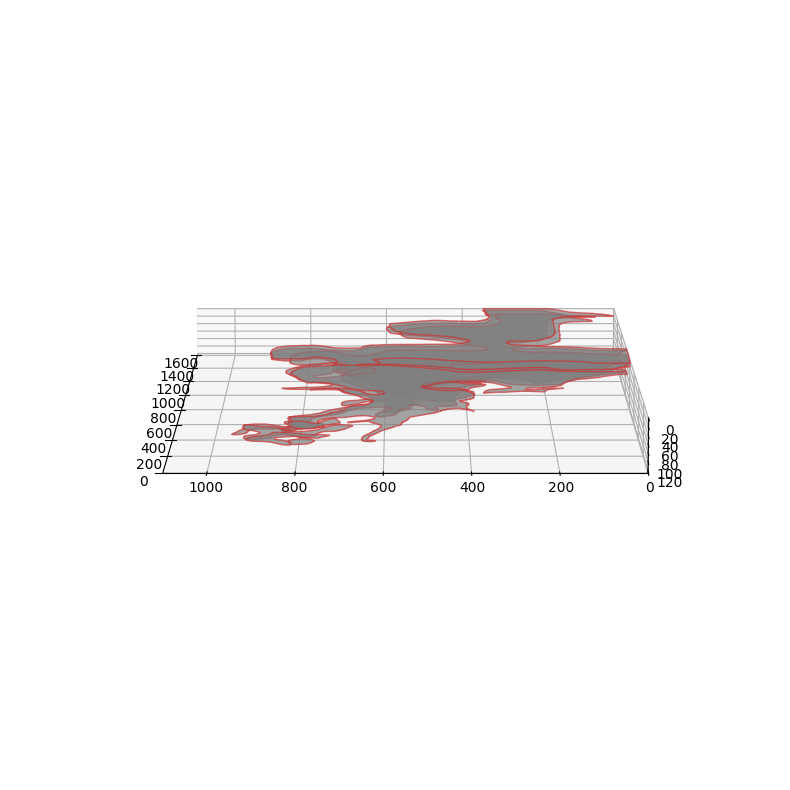

In [171]:
rs = [x for x in regions if x['id'] not in keep]
facecolors = [(.5, .5, .5, 1.)] * len(rs)
edgecolors = [(.2, .2, .2, 1.)] * len(rs)

keep_rs = [x for x in regions if x['id'] in keep]
coords += [x['coordinates'] for x in keep_rs]
zs += [x['position'] for x in keep_rs]
facecolors += [(.5, .5, .5, 1.)] * len(keep_rs)
edgecolors += [(.8, .2, .2, 1.)] * len(keep_rs)

rs += keep_rs

ax = plot_regions(rs, facecolors=facecolors, edgecolors=edgecolors, elev=10., alpha=.7)
plt.savefig(fig_dir / f'{roi}_3d_section_recon.svg')

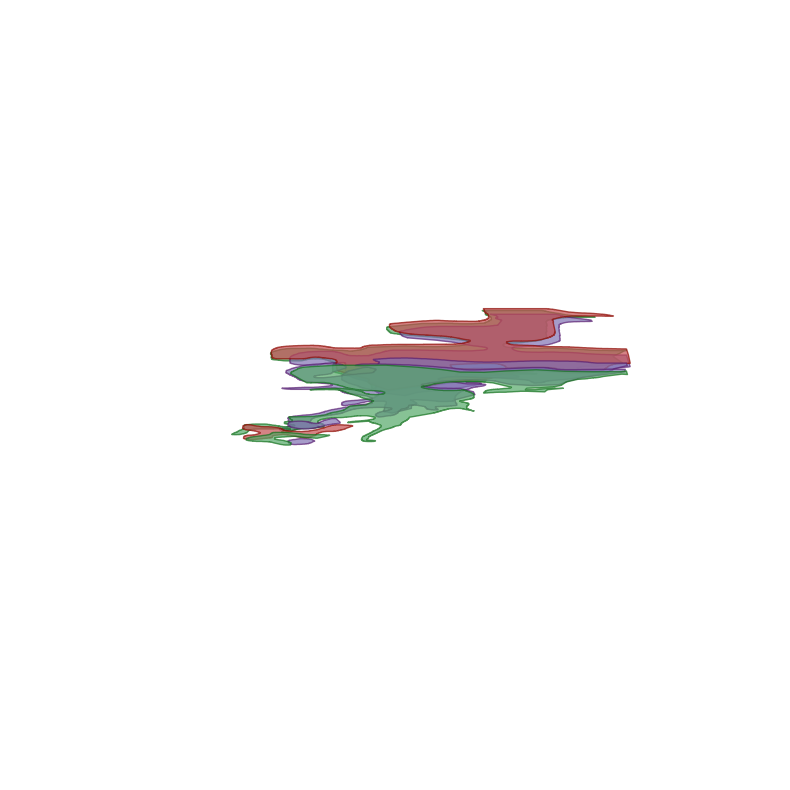

In [172]:
rs = [x for x in regions if x['id'] in keep]
# rs = sorted([x for x in rs], key=lambda x: -x['position'])
# rs = [x for x in rs if x['id'] == 'd9293330-df8b-43f9-8b88-2375643b60aa']
facecolors = [dtype_to_color[x['dtype']] for x in rs]
edgecolors = [dtype_to_edgecolor[x['dtype']] for x in rs]
ax = plot_regions(rs, facecolors=facecolors, edgecolors=edgecolors, alpha=.7, elev=10.)
ax.set_axis_off()

plt.savefig(fig_dir / f'{roi}_3d_section_recon_iso.svg')

###### specialized

In [ ]:
import matplotlib as mpl

In [ ]:
rs = [x for x in regions if x['z']==6]
vals = np.asarray([x['fracs'][dtype_to_channels['xenium'].index('KRT5')] for x in rs])
cmap = mpl.colormaps['viridis']
facecolors = [cmap(v) for v in vals / vals.max()]
edgecolors = (.6, .6, .6, 1.)
ax = plot_regions(rs, facecolors=facecolors, edgecolors=edgecolors, linewidths=1, alpha=1.)
ax.set_axis_off()

plt.savefig(fig_dir / f'{roi}_3d_section_recon_xenium_z6_krt5.svg')

In [ ]:
vals.max()

In [ ]:
z_to_sid = {x['z']:x['sid'] for x in regions}
rgb = sid_to_rgb[z_to_sid[6]].copy()

m = np.zeros((rgb.shape[0], rgb.shape[1]), dtype=bool)
for x in regions:
    if x['z'] == 6:
        m |= x['mask']

expanded = m.copy()
for i in range(4):
    expanded = skimage.morphology.binary_dilation(expanded)

inner = m.copy()
for i in range(2):
    inner = skimage.morphology.binary_erosion(inner)
ring = expanded ^ inner
rgb[ring] = [255, 255, 0]

plt.imshow(rgb)
plt.savefig(fig_dir / f'{roi}_xenium_z6_rgb.svg', dpi=300)

In [ ]:
plt.imshow(m)

###### images for path

In [203]:
case_to_view_details = {
    'HT397B1': {
        'roi1': {
            'radius': 549,
            'thickness': 15,
            'expansion': 40
        },
    },
    'HT206B1': {
        'roi1': {
            'radius': 300,
            'thickness': 10,
            'expansion': 25
        },
        'roi2': {
            'radius': 700,
            'thickness': 20,
            'expansion': 50
        },
    },
    'HT704B1': {
        'roi1': {
            'radius': 250,
            'thickness': 10,
            'expansion': 25
        },
        'roi2': {
            'radius': 200,
            'thickness': 10,
            'expansion': 25
        },
        'roi3': {
            'radius': 600,
            'thickness': 20,
            'expansion': 50
        },
    },
    'HT891Z1': {
        'roi1': {
            'radius': 150,
            'thickness': 8,
            'expansion': 20
        },
        'roi2': {
            'radius': 220,
            'thickness': 10,
            'expansion': 25
        },
        'roi2-p2': {
            'radius': 300,
            'thickness': 10,
            'expansion': 25
        }
    },
    'HT913Z1': {
        'roi1': {
            'radius': 300,
            'thickness': 10,
            'expansion': 25
        },
        'roi1-p2': {
            'radius': 300,
            'thickness': 10,
            'expansion': 25
        }
    },
}

In [204]:
radius = case_to_view_details[case][roi]['radius']
imgs = []
for rid in keep:
    print(rid)
    region = region_id_to_region[rid]
    mask = region['mask']
    
    rlabeled = skimage.morphology.label(mask)
    prop = skimage.measure.regionprops(rlabeled)[0]
    r, c = prop['centroid']
    r, c = int(r), int(c)
    
    r1 = max(0, r - radius)
    c1 = max(0, c - radius)
    r2 = min(mask.shape[0] - 1, r + radius)
    c2 = min(mask.shape[1] - 1, c + radius)
    print(r1, r2, c1, c2)
    diam = radius * 2
    if r2 - r1 < diam:
        if r1 == 0:
            r2 += diam - (r2 - r1)
        else:
            print('here')
            r1 -= diam - (r2 - r1)
    if c2 - c1 < diam:
        if c1 == 0:
            c2 += diam - (c2 - c1)
        else:
            c1 -= diam - (c2 - c1)
    print(r1, r2, c1, c2)
    rgb = sid_to_rgb[region['sid']].copy()
    rgb = rgb[r1:r2, c1:c2]
    mask = mask[r1:r2, c1:c2]
    
    expanded = mask.copy()
    for i in range(case_to_view_details[case][roi]['expansion']):
        expanded = skimage.morphology.binary_dilation(expanded)
    
    inner = expanded.copy()
    for i in range(case_to_view_details[case][roi]['thickness']):
        inner = skimage.morphology.binary_erosion(inner)
    ring = expanded ^ inner
    rgb[ring] = [255, 255, 0]
    
    
    
    imgs.append(rgb)
len(imgs)

28e4e782-02a6-42f5-8b12-5545c85edbc5
0 947 413 1511
0 1098 413 1511
9b273882-70cd-4f31-b2a3-4fcb89a3d861
0 964 404 1502
0 1098 404 1502
9ade75e2-df25-43b5-ad83-8b4bf6575ecd
0 939 422 1520
0 1098 422 1520
57772e61-6c1d-40f1-921d-c79edb578378
0 974 204 1302
0 1098 204 1302
3331f2c7-2ed4-45e8-a9a2-ff1c9ec02a4a
0 1061 188 1286
0 1098 188 1286
b13980e9-baf2-49a2-a226-bb0ba45ccce3
0 1072 140 1238
0 1098 140 1238
c904b121-cc85-4e00-b350-5e6f21f8b64a
219 1099 0 886
here
1 1099 0 1098
e449ad11-2d42-45a8-9264-d395e89191b2
277 1099 0 924
here
1 1099 0 1098
b909d252-1bfe-421d-9183-a2a93cafd163
290 1099 0 874
here
1 1099 0 1098
778fd5c6-456d-45dc-ac09-f72565cd6129
247 1099 0 930
here
1 1099 0 1098


10

28e4e782-02a6-42f5-8b12-5545c85edbc5


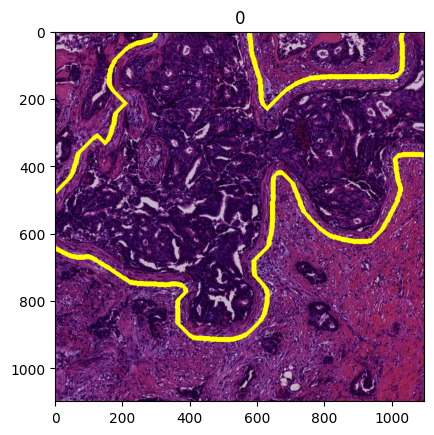

9b273882-70cd-4f31-b2a3-4fcb89a3d861


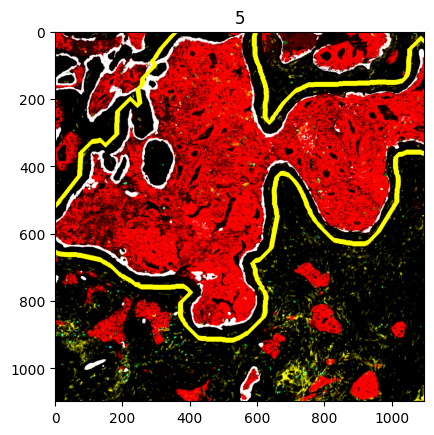

9ade75e2-df25-43b5-ad83-8b4bf6575ecd


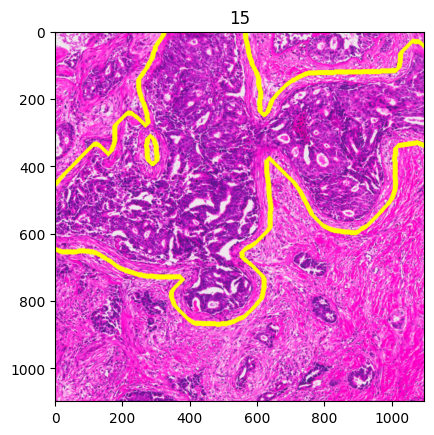

57772e61-6c1d-40f1-921d-c79edb578378


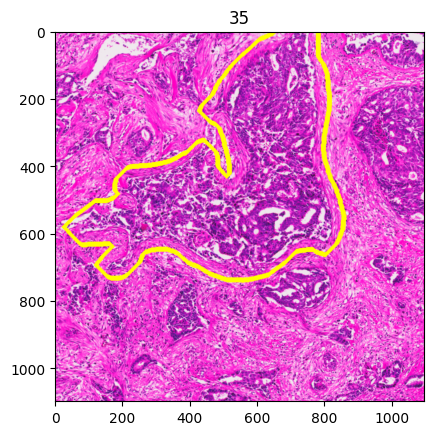

3331f2c7-2ed4-45e8-a9a2-ff1c9ec02a4a


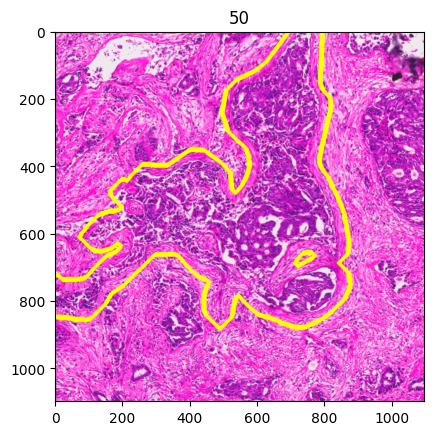

b13980e9-baf2-49a2-a226-bb0ba45ccce3


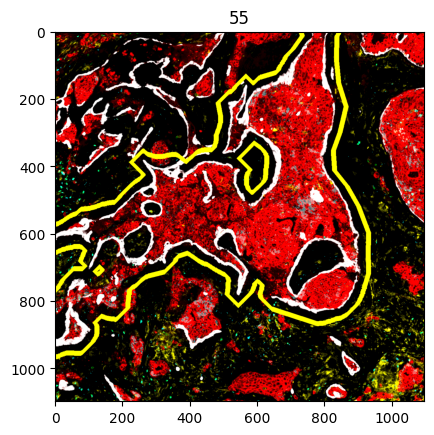

c904b121-cc85-4e00-b350-5e6f21f8b64a


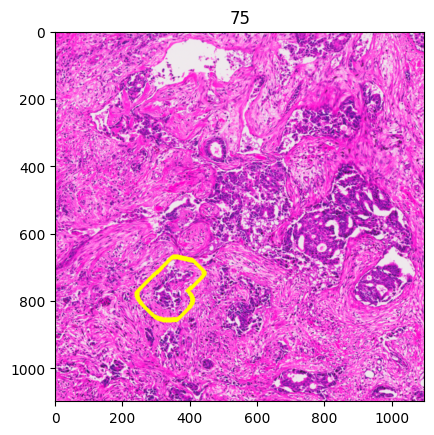

e449ad11-2d42-45a8-9264-d395e89191b2


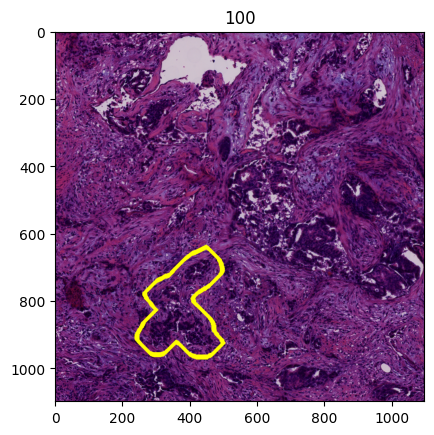

b909d252-1bfe-421d-9183-a2a93cafd163


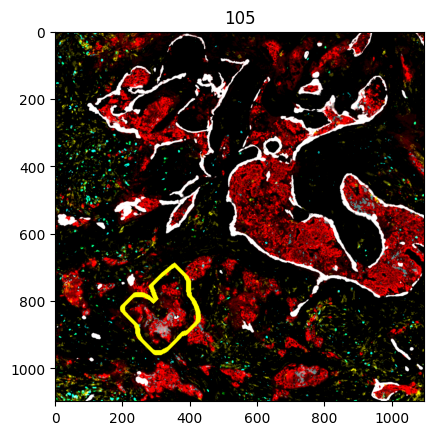

778fd5c6-456d-45dc-ac09-f72565cd6129


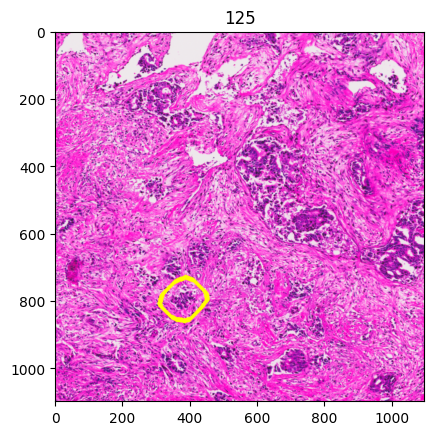

In [205]:

for rid, img in zip(keep, imgs):
    print(rid)
    region = region_id_to_region[rid]
    plt.imshow(img)
    plt.title(region['position'])
    plt.show()

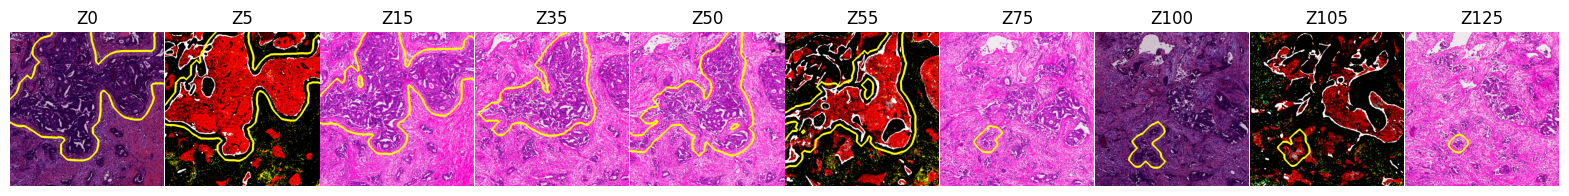

In [206]:
fig, axs = plt.subplots(ncols=len(imgs), figsize=(len(imgs) * 2, 2))

for rid, img, ax in zip(keep, imgs, axs):
    region = region_id_to_region[rid]
    position = region['position']
    
    ax.imshow(img)
    ax.set_axis_off()
    ax.set_aspect('equal')
    
    ax.set_title(f'Z{position}')
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(fig_dir / f'{roi}_all_images.svg', dpi=300)

In [228]:
case_to_pathology_annotations = {
    'HT397B1': {
        'roi1': {
            '28e4e782-02a6-42f5-8b12-5545c85edbc5': 'DCIS',
            '3331f2c7-2ed4-45e8-a9a2-ff1c9ec02a4a': 'IDC - partial',
            'c904b121-cc85-4e00-b350-5e6f21f8b64a': 'IDC'
        },
    },
    'HT206B1': {
        'roi1': {
            '78ddd8ed-908d-4b95-bdd0-f94cae4064d2': 'DCIS',
            'a15f9fc3-9a15-4bbc-a566-a9f62f83a6e2': 'IDC - partial',
            '132a3bbb-01de-49f6-a5f6-9abab2724546': 'IDC'
        },
        'roi2': {
            '9b6c4b7c-334e-44c1-913d-ad3a85c19037': 'DCIS',
            '39a9a982-8b02-4a1e-a09f-ddf4a1ab9e06': 'IDC - partial',
            '9b741c21-1ea5-4b83-abf9-e0b51cba93c1': 'IDC'
        },
    },
    'HT704B1': {
        'roi1': {
            'b28d28d2-098a-41aa-8a99-24f8c8753897': 'DCIS',
            '8f7fd7f0-ca13-43d5-a8a5-bc46e8f9b687': 'IDC - partial',
            'a4719551-76dd-4117-a82a-c086568f52f2': 'IDC'
        },
        'roi2': {
            'c2df8514-9463-481a-9b68-c81dd634bb9a': 'DCIS',
            '244c386c-93ac-4a5f-bf52-43dcce7a1388': 'IDC - partial'
        },
        'roi3': {
            'd9293330-df8b-43f9-8b88-2375643b60aa': 'DCIS'
        }
    },
    'HT891Z1': {
        'roi1': {
            '18073a83-5d22-4c2a-8cc8-e1b27a4de88e': 'Normal',
            'f478fe10-a739-49b6-a66b-e78a89114bb8': 'HG PIN',
            '5360344d-4cc6-495c-88c8-920d753afa68': 'GP3'
        },
        'roi2': {
            '4fd912e9-9eda-4290-aab8-8cfb9bfedb43': 'Normal',
            '7a3535f1-c30c-40c1-9d31-24c2ee7e58f9': 'HG PIN',
            '9ddde78f-2e7b-4259-9bf9-efdd0a005b79': 'GP3'
        },
        'roi2-p2': {
            '406ac3bf-8609-4786-a1df-6540b4970cea': 'GP3',
            'fc0a0ccf-7386-416f-b163-99041f2d8918': 'HG PIN',
            '9ddde78f-2e7b-4259-9bf9-efdd0a005b79': 'GP3'
        }
    },
    'HT913Z1': {
        'roi1': {
            'f3ae0453-4fd5-4160-8152-c3e4853df1f6': 'Normal',
            'a1c63d7a-d930-4836-b680-55014c4d272c': 'HG PIN',
            '5ea70ce2-e418-483d-89f6-eea5e0d721aa': 'Normal',
        },
        'roi1-p2': {
            'f3ae0453-4fd5-4160-8152-c3e4853df1f6': 'Normal',
            'a1c63d7a-d930-4836-b680-55014c4d272c': 'HG PIN',
            '0d40da4f-96d8-4c16-8865-5826b89c7cd8': 'GP3',
        },
    }
}

case_to_pathology_colors = {
    'HT397B1': {
        'IDC': [150, 29, 138],
        'IDC - partial': [171, 20, 12],
        'DCIS': [191, 128, 11],
        'Normal': [36, 117, 15]
    },
    'HT206B1': {
        'IDC': [150, 29, 138],
        'IDC - partial': [171, 20, 12],
        'DCIS': [191, 128, 11],
        'Normal': [36, 117, 15]
    },
    'HT704B1': {
        'IDC': [150, 29, 138],
        'IDC - partial': [171, 20, 12],
        'DCIS': [191, 128, 11],
        'Normal': [36, 117, 15]
    },
    'HT891Z1': {
        'GP3': [150, 29, 138],
        'HG PIN': [191, 128, 11],
        'Normal': [36, 117, 15]
    },
    'HT913Z1': {
        'GP3': [150, 29, 138],
        'HG PIN': [191, 128, 11],
        'Normal': [36, 117, 15]
    }
}

pathology_order = ['Normal', 'DCIS', 'IDC - partial', 'IDC'] # used for fold changes
# pathology_order = ['Normal', 'HG PIN', 'GP3'] # used for fold changes


In [208]:
region_id_to_path = {}
annots = case_to_pathology_annotations[case][roi]
current = None
for k in keep:
    if k in annots:
        current = annots[k]
    region_id_to_path[k] = current
region_id_to_path

{'28e4e782-02a6-42f5-8b12-5545c85edbc5': 'DCIS',
 '9b273882-70cd-4f31-b2a3-4fcb89a3d861': 'DCIS',
 '9ade75e2-df25-43b5-ad83-8b4bf6575ecd': 'DCIS',
 '57772e61-6c1d-40f1-921d-c79edb578378': 'DCIS',
 '3331f2c7-2ed4-45e8-a9a2-ff1c9ec02a4a': 'IDC - partial',
 'b13980e9-baf2-49a2-a226-bb0ba45ccce3': 'IDC - partial',
 'c904b121-cc85-4e00-b350-5e6f21f8b64a': 'IDC',
 'e449ad11-2d42-45a8-9264-d395e89191b2': 'IDC',
 'b909d252-1bfe-421d-9183-a2a93cafd163': 'IDC',
 '778fd5c6-456d-45dc-ac09-f72565cd6129': 'IDC'}

In [209]:
reg_dir = imaris_dir / 'regions'
reg_dir.mkdir(parents=True, exist_ok=True)

In [210]:
d = {
    'case_to_pathology_annotations': case_to_pathology_annotations,
    'case_to_pathology_colors': case_to_pathology_colors,
    'pathology_order': pathology_order,
    'region_id_to_pathology': region_id_to_path,
    'region_ids': keep,
    'dtypes': [region_id_to_region[k]['dtype'] for k in keep],
    'sids': [region_id_to_region[k]['sid'] for k in keep]
}
json.dump(d, open(reg_dir / f'{roi}_metadata.json', 'w'))

###### heatmaps

In [211]:
def get_means_and_fracs(region_id_to_regions, paths, dtype_ident, mean_key='means', frac_key='fracs', dti_to_channel_idxs=None):
    results = []
    for path in paths:
        vals, fracs, zs, other_vals, other_fracs, ids = [], [], [], [], [], []
        for k in path:
            if isinstance(k, int):
                region = region_id_to_region[label_to_region_id[k]]
            else:
                region = region_id_to_region[k]

            if dti_to_channel_idxs is not None:
                print(f'using {dti_to_channel_idxs.keys()}')
                condition = 'dtype_ident' in region and region['dtype_ident'] in dti_to_channel_idxs
                idxs = dti_to_channel_idxs[region['dtype_ident']] if condition else None
            else:
                print(f'gathering dti {dtype_ident}')
                condition = 'dtype_ident' in region and region['dtype_ident'] == dtype_ident
                idxs = np.arange(len(region[mean_key]))
            if condition:
                vals.append(region[mean_key][idxs])
                fracs.append(region[frac_key][idxs])
                zs.append(region['position'])
                
                rs = [x for x in region_id_to_region.values()
                      if x['position']==region['position'] and x['id']!=region['id']]
                if rs:
                    other_vals.append(np.stack([x[mean_key][idxs] for x in rs]))
                    other_fracs.append(np.stack([x[frac_key][idxs] for x in rs]))
                else:
                    other_vals.append(None)
                    other_fracs.append(None)
                
                ids.append(k)
                
        if vals:
            vals, fracs = np.stack(vals), np.stack(fracs)
            vals, fracs = rearrange(vals, 'd n -> n d'), rearrange(fracs, 'd n -> n d')
            results.append({
                'vals': vals,
                'fracs': fracs,
                'other_vals': other_vals,
                'other_fracs': other_fracs,
                'zs': zs,
                'region_ids': ids
            })
    return results

import scipy
def get_correlations(vals, default=0.):
    coors, pvals = [], []
    for row in vals:
        r = scipy.stats.pearsonr(row, np.arange(len(row)))
        if not pd.isnull(r.pvalue):
            coors.append(r.correlation)
            pvals.append(r.pvalue)
        else:
            coors.append(default)
            pvals.append(1.)
    return np.asarray(coors), np.asarray(pvals)

def get_fold_changes(vals, annots):
    df = pd.DataFrame(data=vals).T
    df['annot'] = annots
    
    present = sorted(set([x for x in annots]), key=lambda x: pathology_order.index(x))
    print(present)
    pvals_data, statistic_data, fc_data, indices = [], [], [], []
    for i, annot1 in enumerate(present[:-1]):
        annot2 = present[i + 1]
        
        xs = df[df['annot']==annot1].values[:, :-1].astype(float)
        ys = df[df['annot']==annot2].values[:, :-1].astype(float)
        
        statistic_row, pvals_row, fc_row = [], [], []
        for j in range(df.shape[1] - 1):
            r = scipy.stats.ttest_ind(xs[:, j], ys[:, j])
            statistic_row.append(r.statistic)
            pvals_row.append(r.pvalue)

            a, b = xs[:, j].mean(), ys[:, j].mean()
            a, b = a + 1, b + 1
            fc = (b - a) / a
            fc_row.append(fc)
        
        pvals_data.append(pvals_row)
        statistic_data.append(statistic_row)
        fc_data.append(fc_row)
        
        indices.append(f'{annot1}_{annot2}')
    
    pvals_df = pd.DataFrame(data=pvals_data, index=indices)
    statistic_df = pd.DataFrame(data=statistic_data, index=indices)
    fc_df = pd.DataFrame(data=fc_data, index=indices)
    
    
    return fc_df, pvals_df, statistic_df

In [212]:
# dtype_ident = 'xenium_0'
# dtype_ident = 'xenium_1'
# dtype_ident = 'cosmx_0'
# dtype_ident = 'vishd_0'
dtype_ident = 'visium_0'

exp_delta_cut = .0
channels = dtype_ident_to_channels[dtype_ident]
print(len(channels))

result = get_means_and_fracs(region_id_to_region, [keep], dtype_ident)[0]
result.keys()

17943
gathering dti visium_0
gathering dti visium_0
gathering dti visium_0
gathering dti visium_0
gathering dti visium_0
gathering dti visium_0
gathering dti visium_0
gathering dti visium_0
gathering dti visium_0
gathering dti visium_0


dict_keys(['vals', 'fracs', 'other_vals', 'other_fracs', 'zs', 'region_ids'])

In [213]:
# # run this to merge dti's
# dtype_ident = 'xenium_combined'
# root = dtype_ident.split('_')[0]
# dtis = [x for x in dtype_ident_to_channels.keys() if root in x]
# assert len(dtis) > 1

# all_channels = [set(dtype_ident_to_channels[dti]) for dti in dtis]
# channels = sorted(set.intersection(*all_channels))
# assert len(channels) > 0

# common_dtis_to_idxs = {}
# for dti in dtis:
#     idxs = np.asarray([dtype_ident_to_channels[dti].index(c) for c in channels])
#     common_dtis_to_idxs[dti] = idxs

# result = get_means_and_fracs(region_id_to_region, [keep], dtype_ident, dti_to_channel_idxs=common_dtis_to_idxs)[0]
# result.keys()

In [214]:
result['vals'].shape

(17943, 2)

In [215]:
annots

{'28e4e782-02a6-42f5-8b12-5545c85edbc5': 'DCIS',
 '3331f2c7-2ed4-45e8-a9a2-ff1c9ec02a4a': 'IDC - partial',
 'c904b121-cc85-4e00-b350-5e6f21f8b64a': 'IDC'}

In [216]:
# coors, pvals = get_correlations(result['vals'])
vals, fracs, zs, other_vals, other_fracs = result['vals'], result['fracs'], result['zs'], result['other_vals'], result['other_fracs']
annots = [region_id_to_path[rid] for rid in result['region_ids']]
fc_df, pvals_df, statistic_df = get_fold_changes(vals, annots)
fc_df.columns = channels
pvals_df.columns = channels
statistic_df.columns = channels
fc_df

['DCIS', 'IDC']


/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/scipy/stats/_stats_py.py:6558: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


SAMD11     NOC2L    KLHL17   PLEKHN1  PERM1      HES4     ISG15  \
DCIS_IDC -0.261682 -0.457843 -0.081395 -0.240385    0.0 -0.522298 -0.486179   

              AGRN  RNF223  C1orf159  ...  SRY  ZFY  PCDH11Y  AMELY  TBL1Y  \
DCIS_IDC -0.394003     0.0 -0.507788  ...  0.0  0.0      0.0    0.0    0.0   

          TSPY1  USP9Y  DDX3Y  TMSB4Y  KDM5D  
DCIS_IDC    0.0    0.0    0.0     0.0    0.0  

[1 rows x 17943 columns]

In [217]:
exp_df = pd.DataFrame(data=vals, columns=result['region_ids'], index=channels).T
exp_df

SAMD11     NOC2L    KLHL17   PLEKHN1  \
28e4e782-02a6-42f5-8b12-5545c85edbc5  0.35443  3.303797  0.088608  0.316456   
e449ad11-2d42-45a8-9264-d395e89191b2  0.00000  1.333333  0.000000  0.000000   

                                      PERM1      HES4     ISG15      AGRN  \
28e4e782-02a6-42f5-8b12-5545c85edbc5    0.0  4.582278  1.594937  5.050633   
e449ad11-2d42-45a8-9264-d395e89191b2    0.0  1.666667  0.333333  2.666667   

                                      RNF223  C1orf159  ...  SRY  ZFY  \
28e4e782-02a6-42f5-8b12-5545c85edbc5     0.0  1.708861  ...  0.0  0.0   
e449ad11-2d42-45a8-9264-d395e89191b2     0.0  0.333333  ...  0.0  0.0   

                                      PCDH11Y  AMELY  TBL1Y  TSPY1  USP9Y  \
28e4e782-02a6-42f5-8b12-5545c85edbc5      0.0    0.0    0.0    0.0    0.0   
e449ad11-2d42-45a8-9264-d395e89191b2      0.0    0.0    0.0    0.0    0.0   

                                      DDX3Y  TMSB4Y  KDM5D  
28e4e782-02a6-42f5-8b12-5545c85edbc5    0.0     0.0    0.0  
e449ad11-2d42-45a8-9264-d395e89191b2    0.0     0.0    0.0  

[2 rows x 17943 columns]

In [218]:
pvals_df

SAMD11  NOC2L  KLHL17  PLEKHN1  PERM1  HES4  ISG15  AGRN  RNF223  \
DCIS_IDC     NaN    NaN     NaN      NaN    NaN   NaN    NaN   NaN     NaN   

          C1orf159  ...  SRY  ZFY  PCDH11Y  AMELY  TBL1Y  TSPY1  USP9Y  DDX3Y  \
DCIS_IDC       NaN  ...  NaN  NaN      NaN    NaN    NaN    NaN    NaN    NaN   

          TMSB4Y  KDM5D  
DCIS_IDC     NaN    NaN  

[1 rows x 17943 columns]

In [219]:
idxs = np.argsort(fc_df.mean(0).values)
ordered = np.asarray(channels)[idxs]
ordered

array(['S100A7', 'S100A9', 'CLU', ..., 'DGKI', 'ZNF720', 'COL5A3'],
      dtype='<U14')

In [220]:
# idxs = np.argsort(coors)
# m = np.asarray([x > .2 for x in fracs[idxs].max(-1)])
# m &= pvals[idxs] < p_value_cut
# idxs = idxs[m]

# ordered = np.asarray(channels)[idxs]

# ordered

In [221]:
n = 30

data = vals[idxs[:n]]
data = np.concatenate((data, vals[idxs[-n:]]))
source = pd.DataFrame(data=data.T, columns=np.concatenate((ordered[:n], ordered[-n:])), index=zs)
m = np.asarray((source.max(0) - source.min(0))) > exp_delta_cut
source = source[source.columns[m]]

source = source[[c for c in source.columns if 'MT-' not in c]] # get rid if MT genes

# data = vals[idxs]
# data -= data.min(1, keepdims=True)
# source = pd.DataFrame(data=data.T, columns=ordered, index=zs)
source

S100A7     S100A9        CLU      UQCRQ     DUSP4     CRABP2  \
0    21.063292  42.936710  18.101265  10.607594  9.582278  13.291140   
100   1.000000   4.666667   1.666667   0.666667  0.666667   1.333333   

         NQO1      TC2N      CNDP2      RDH10  ...       FOS   COL11A1  \
0    5.101266  6.860759  10.658228  12.493670  ...  2.025316  1.848101   
100  0.000000  0.333333   1.000000   1.333333  ...  5.000000  4.666667   

        ITGB2    ELOVL6  ADAMTS16       ENG   OLFML2B      DGKI    ZNF720  \
0    0.329114  0.151899  0.151899  1.240506  1.037975  0.088608  0.075949   
100  1.666667  1.333333  1.333333  3.666667  3.333333  1.333333  1.333333   

       COL5A3  
0    0.481013  
100  2.333333  

[2 rows x 60 columns]

In [222]:
fig_dir

PosixPath('/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/figures')

In [223]:
# fig, ax = plt.subplots(figsize=(25, 20))
# sns.heatmap(source, cmap='Blues')
# plt.savefig(fig_dir / f'{roi}_{dtype_ident}_gene_heatmap.svg')

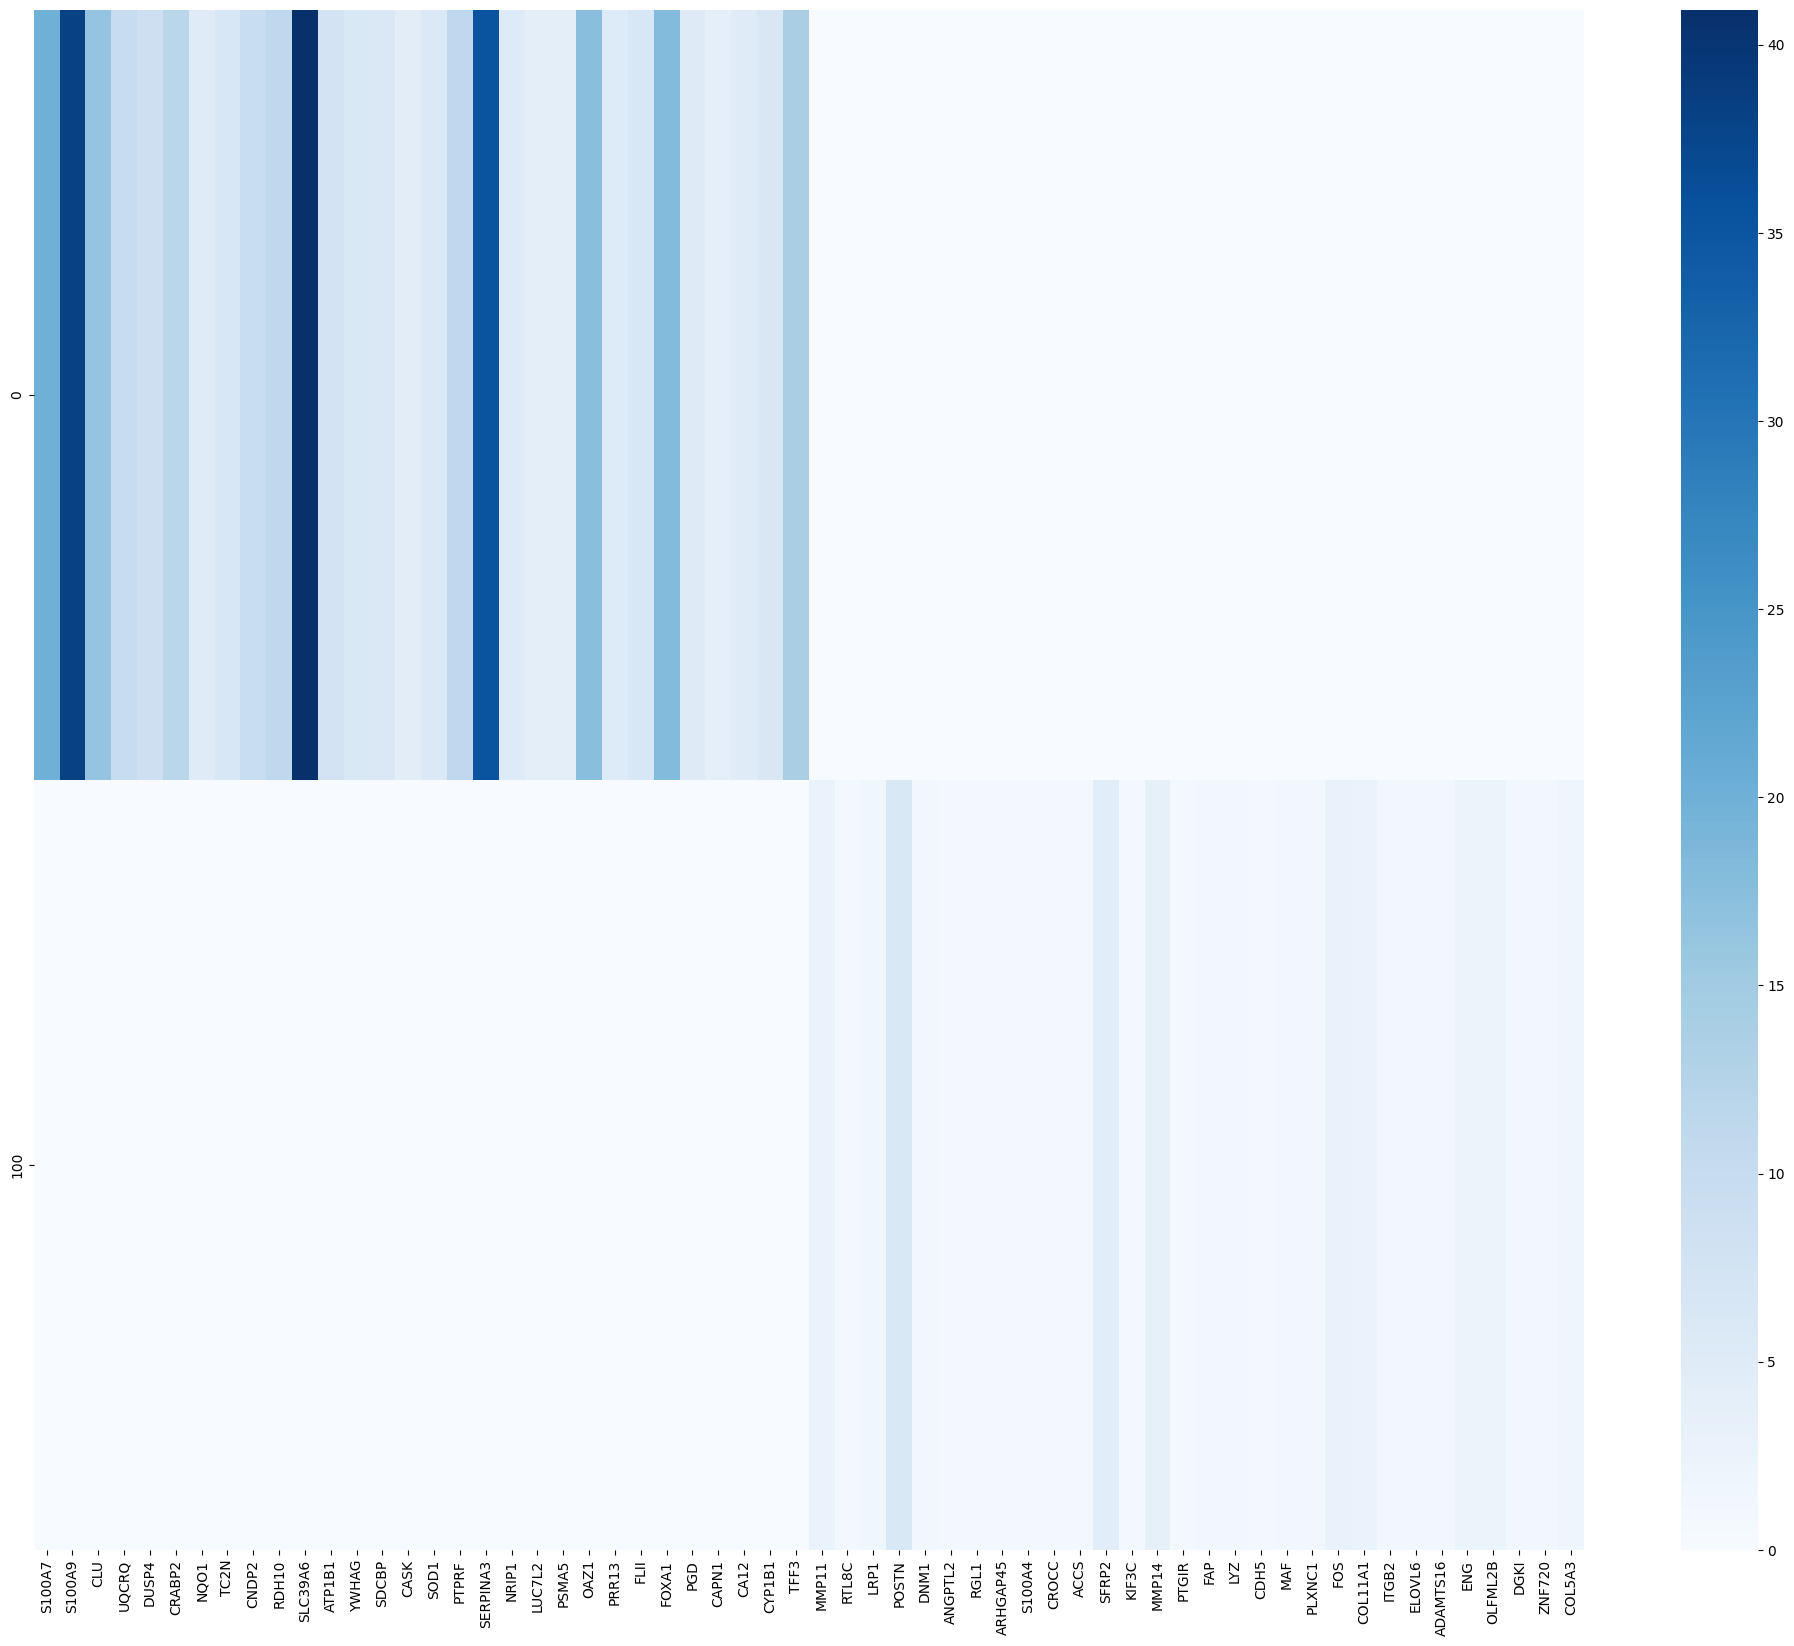

In [224]:
fig, ax = plt.subplots(figsize=(25, 20))
# vmax = 4.
vmax = None
sns.heatmap(source - source.min(0), cmap='Blues', vmax=vmax)
plt.savefig(fig_dir / f'{roi}_{dtype_ident}_gene_heatmap.svg')

/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


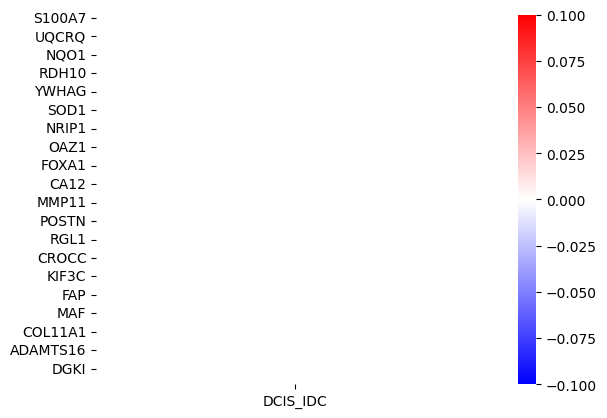

In [225]:
df = statistic_df.T.loc[source.columns]
divnorm = TwoSlopeNorm(vmin=df.values.min(), vcenter=0., vmax=df.values.max())
sns.heatmap(df, cmap='bwr', norm=divnorm)
plt.savefig(fig_dir / f'{roi}_{dtype_ident}_gene_heatmap_statistic.svg')

/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


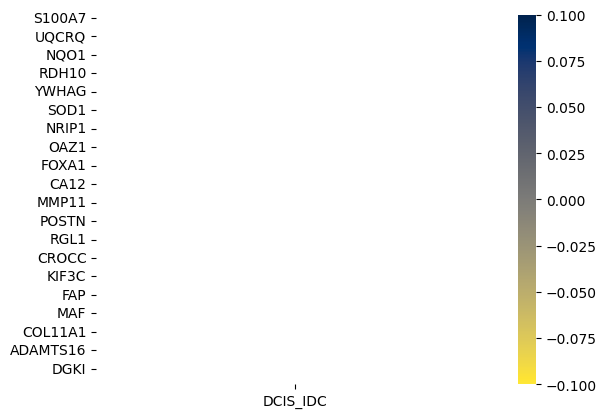

In [226]:
sns.heatmap(pvals_df.T.loc[source.columns], cmap='cividis_r', vmin=0)
plt.savefig(fig_dir / f'{roi}_{dtype_ident}_gene_heatmap_pvals.svg')

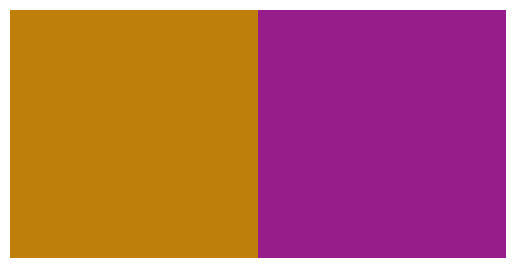

In [229]:
rids = result['region_ids']
tiles = []
for rid in rids:
    annot = region_id_to_path[rid]
    color = case_to_pathology_colors[case][annot]
    tile = np.zeros((50, 50, 3), dtype=np.uint8)
    tile[...] = color
    tiles.append(tile)
bar = np.concatenate(tiles, axis=1)
plt.imshow(bar)
plt.axis('off')
plt.savefig(fig_dir / f'{roi}_{dtype_ident}_gene_heatmap_pathology.svg')

In [230]:
result_dir = imaris_dir / 'results'
result_dir.mkdir(parents=True, exist_ok=True)

In [231]:
exp_df.index.name = 'region_id'
exp_df.to_csv(result_dir / f'{roi}_{dtype_ident}_expression.txt.gz', sep='\t')

In [232]:
fc_df.index.name = 'transition_id'
fc_df.to_csv(result_dir / f'{roi}_{dtype_ident}_fc.txt.gz', sep='\t')

In [233]:
pvals_df.index.name = 'transition_id'
pvals_df.to_csv(result_dir / f'{roi}_{dtype_ident}_pvals.txt.gz', sep='\t')

In [234]:
statistic_df.index.name = 'transition_id'
statistic_df.to_csv(result_dir / f'{roi}_{dtype_ident}_statistics.txt.gz', sep='\t')

In [235]:
d = {
    'exp_delta_cut': exp_delta_cut,
#     'vmax': vmax,
    'channels': channels
}
json.dump(d, open(result_dir / f'{roi}_{dtype_ident}_metadata.json', 'w'))

In [236]:
result_dir

PosixPath('/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/imaris/rois/results')

In [389]:
# gene = 'ALDH1A3'
# r1, r2, c1, c2 = [x // tiling_resolution for x in [R1, R2, C1, C2]]
# for sid, tiled in sid_to_tiled.items():
#     dtype = sid_to_dtype[sid]
#     rgb = sid_to_rgb[sid]
#     z = sid_to_z[sid]
#     m = z_to_regions_mask[z]
#     mm = skimage.morphology.binary_dilation(m)
#     m = mm ^ m
    
#     if dtype == 'xenium':
#         fig, ax = plt.subplots(ncols=2)
#         x = tiled[dtype_to_channels[dtype].index(gene)]
#         x = np.stack([x, x, x], -1)
#         x[m] = [x.max(), 0, 0]
#         x = x[r1:r2, c1:c2]
#         x /= x.max()
# #         x = utils.rescale(x, size=rgb.shape[:2], dim_order='h w c', target_dtype=x.dtype)
#         print(x.shape, m.shape)
# #         x[m] = [1, 0, 0]
#         ax[0].imshow(x)
#         ax[0].set_title(z)
#         ax[1].imshow(rgb)
#         plt.show()

In [338]:
imaris_dir

PosixPath('/data/estorrs/mushroom/data/projects/submission_v1/HT891Z1/imaris/rois')